In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from numpy import genfromtxt
from trueskill import TrueSkill, Rating, quality_1vs1, rate_1vs1
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
from matplotlib import cm
from scipy import stats
import operator as op
import pandas as pd
from ast import literal_eval
from mpl_toolkits.mplot3d import Axes3D
import math
import sys

import mygabasic as ga
 
%aimport mygabasic

HOlA MYGABASIC


In [606]:
#import os
#os.getcwd()

'/Users/SerG1oAC/Documents/EvolutiveComputing/notebook'

In [607]:
#import sys
#sys.path.append('/Users/SerG1oAC/Documents/EvolutiveComputing/notebook')

# Rastrigin function
## Optimization Methods
---
https://www.sfu.ca/~ssurjano/schwef.html

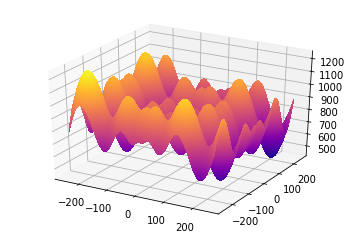

In [2]:
def schwefel(*X, **kwargs):
    A = kwargs.get('A', 2)
    # return 418.9829*A + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in X])
    return 418.9829*A - sum([(x*np.sin(np.sqrt(np.absolute(x)))) for x in X])


    

if __name__ == '__main__':
    X = np.linspace(-250, 250, 1000)    
    Y = np.linspace(-250, 250, 1000)    

    X, Y = np.meshgrid(X, Y)

    Z = schwefel(X, Y, A=2)

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False)    
    plt.savefig('schwefel', format='pdf')


## Simulated Annealing
---
### Cooling Schedule

Now we must define the functions that constitute our cooling schedule. We reduce the temperature by a multiplicative factor of 0.8, and increase the epoch length by a factor of 1.2

In [3]:
tf = lambda t: 0.8*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

### Running the Algorithm

We define the `sa` function that takes a set of initial conditions, on temperature, length of epoch, and starting point, the energy function, the number or opochs to run, the cooling schedule, and the proposal, and implements the algorithm defined above. Our algorithms structure is that of running for some epochs during which we reduce the temperature and increase the epoch iteration length. This is somewhat wasteful, but simpler to code, although it is not too complex to build in stopping conditions.

In [4]:
def sa(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc,sigma = 0.75,x1 = 20,x0 = 0.5,alpha = -1.5):
    # out plot
    OUT_List_Simanneal = []
    Iterations = []
    
    accumulator=[]
    best_solution = old_solution = initials['solution']
    T=initials['T']
    length=initials['length']
    best_energy = old_energy = energyfunc(old_solution)
    accepted=0
    total=0
    
    best_index=total
    best_temp=T
    
    
    for index in range(epochs):
        # print("Epoch", index)
        if index > 0:
            T = tempfunc(T)
            length=iterfunc(length)
            sys.stdout.write("\r Temperature " + str(T))
            sys.stdout.flush()
        # print("Temperature", T, "Length", length)
        for it in range(length):
            Iterations.append(total)
            OUT_List_Simanneal.append(old_energy)
            total+=1
            new_solution = np.copy(old_solution)
            for y in new_solution:
                if proposalfunc == 'rdmGauss':
                    y[0] = y[0] + rdmGauss(sigma = sigma)
                else:
                    y[0] = y[0] + rdmSimetricPoerLow(x1 = x1, x0 = x0, alpha = alpha)
                if y[0] < -500 :
                    y[0] = -500
                elif y[0] > 500:
                    y[0] = 600
                    
            # new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            # Use a min here as you could get a "probability" > 1
            alphaLoc = min(1, np.exp((old_energy - new_energy)/T))
            if ((new_energy < old_energy) or (np.random.uniform() < alphaLoc)):
                # Accept proposed solution
                accepted+=1
                accumulator.append((T, new_solution, new_energy))
                #OUT_List_Simanneal.append(new_energy)
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Keep the old stuff
                accumulator.append((T, old_solution, old_energy))
                #OUT_List_Simanneal.append(old_energy)
    
    best_meta=dict(index=best_index, temp=best_temp)
    # print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    return best_meta, best_solution, best_energy, accumulator, OUT_List_Simanneal, Iterations

In [5]:
# http://mathworld.wolfram.com/RandomNumber.html
# https://stackoverflow.com/questions/918736/random-number-generator-that-produces-a-power-law-distribution
def rdmSimetricPoerLow(x1 = 100, x0 = 10, alpha = -1.5):
    y = np.random.uniform(0,1,1)
    x = math.pow((math.pow(x1, (alpha + 1)) - math.pow(x0, (alpha + 1)))*y + math.pow(x0, (alpha + 1)),(1/(alpha+1)))
    sign = np.random.uniform(0,1,1)
    return x if sign > 0.5 else -x

In [6]:
def rdmGauss(sigma = 0.2, mu = 0):
    return np.random.normal(mu, sigma, 1)

In [4]:
def Schwefel(fevalMtx):
    dim = fevalMtx.shape[0]
    return 418.9829*dim - sum([(x[0]*np.sin(np.sqrt(np.absolute(x[0])))) for x in fevalMtx])

def SchwefelBinString(binString):
    codeLen = 16 
    cromoSize = binString.shape[0]
    col = int(cromoSize/codeLen)
    splitPop = binString.reshape((col,codeLen))
    # print(splitPop)
    fevalMtx = [[ga.gdeco(bitlist = dim, minVal = 100, maxVal = 500, codeLen = codeLen)] for dim in splitPop]
    # print(fevalMtx)
    rval =  Schwefel(np.asarray(fevalMtx))
    # print(rval)
    return rval

In [8]:
def SchwefelGradient(fevalMtx):
    delta = np.zeros((fevalMtx.shape[0], 1))
    for i in range(fevalMtx.shape[0]):
        if fevalMtx[i][0] >= 0:
            innerDerivetive = 1/(np.sqrt(fevalMtx[i][0])*2)
        else:
            innerDerivetive = -1/(np.sqrt(-fevalMtx[i][0])*2)
        delta[i][0] = -np.sin(np.sqrt(np.absolute(fevalMtx[i][0]))) - fevalMtx[i][0]*np.cos(np.sqrt(np.absolute(fevalMtx[i][0])))*innerDerivetive
   
    return delta

In [9]:
def min_SchwefelPowerLaw(fevalMtx, x1 = 10, x0 = 1, alpha = -1.5):
    Y = np.copy(fevalMtx)
    for y in Y:
        y[0] = y[0] + rdmSimetricPoerLow(x1 = x1, x0 = x0, alpha = alpha)
        
        if y[0] < -500 :
            y[0] = -500
        elif y[0] > 500:
            y[0] = 500
    
    prev = Schwefel(fevalMtx);
    new = Schwefel(Y);
    
    if new <= prev:
        return new, Y
    else:
        return prev, fevalMtx
            

In [10]:
def min_SchwefelHill(fevalMtx,sigma = 1.81):
    Y = np.copy(fevalMtx)
    for y in Y:
        y[0] = y[0] + rdmGauss(sigma = sigma)
        
        if y[0] < -500 :
            y[0] = -500
        elif y[0] > 500:
            y[0] = 500
    
    prev = Schwefel(fevalMtx);
    new = Schwefel(Y);
    
    if new <= prev:
        return new, Y
    else:
        return prev, fevalMtx

In [11]:
def min_SchwefelGradient(fevalMtx, delta, alpha = 0.5, miu = 0.7):
    alpha = alpha;
    miu = miu;
    grad = SchwefelGradient(fevalMtx)
    Y = np.copy(fevalMtx)
    for i in range(fevalMtx.shape[0]):
        delta[i][0] =  miu * delta[i][0] - grad[i][0] * alpha
        Y[i][0] = Y[i][0] + delta[i][0]
        
        if Y[i][0] < -500 :
            Y[i][0] = -500
        elif Y[i][0] > 500:
            Y[i][0] = 500
    
    
    new = Schwefel(Y);
    
    return new, Y, delta 

# min_SchwefelPowerLaw
## 2D

 Iteration 29

mean: 19.371722920902013
std: 51.07472080783144
median: 0.3116186470095954
min: 0.12293979603646221
max: 217.31895684290134


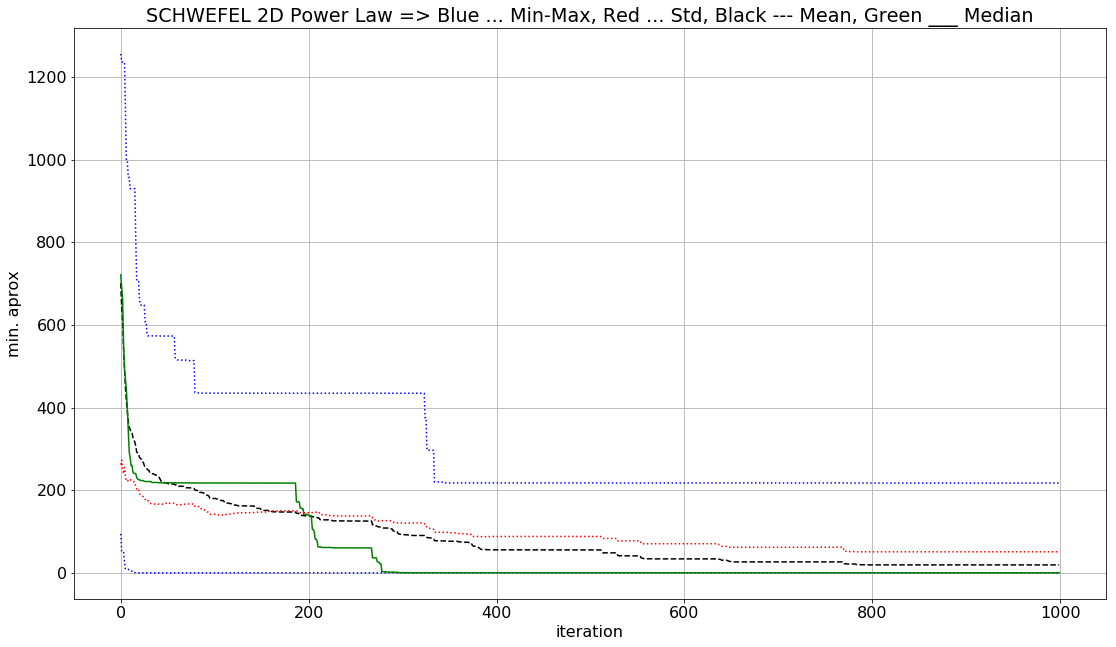

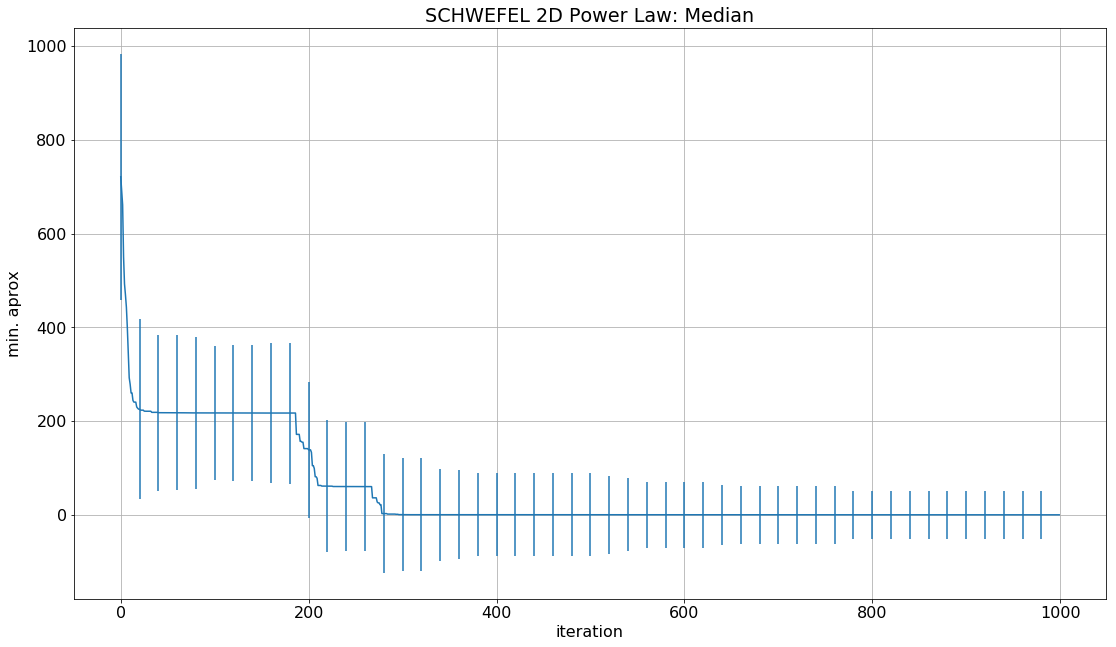

In [294]:
Best_List = []
valVectorSize = 2

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=100, high=500, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm = min_SchwefelPowerLaw(fevalRdm, x1 = 200, x0 = 2, alpha = -1.5)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))



# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 2D Power Law => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('schwefelPowerLaw_2d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:20] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 2D Power Law: Median")
plt.grid()
plt.savefig('schwefelPowerLawStd_2d.pdf', format='pdf')
plt.show()

# min_SchwefelPowerLaw
## 10D

 Iteration 29

mean: 42.1887962153529
std: 63.7627615522238
median: 3.0471611809948627
min: 1.4167770803778694
max: 239.62236447883788
[[418.20935017]
 [423.8337804 ]
 [421.46669978]
 [422.78002457]
 [422.5907541 ]
 [422.35171289]
 [421.110843  ]
 [423.27852784]
 [421.51721379]
 [418.57092943]]


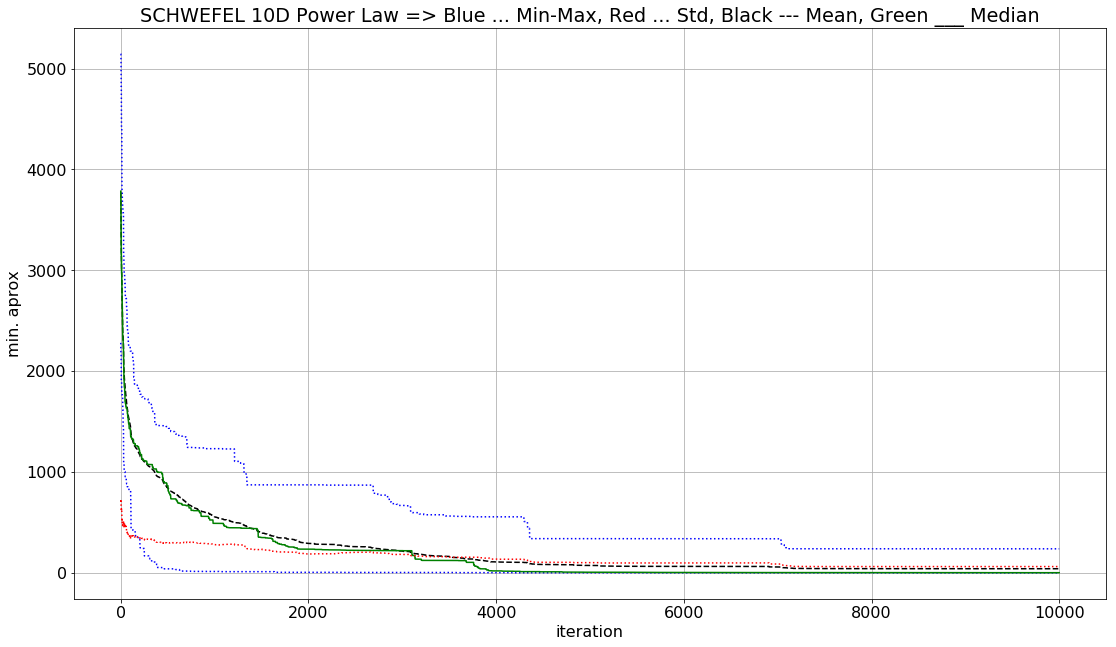

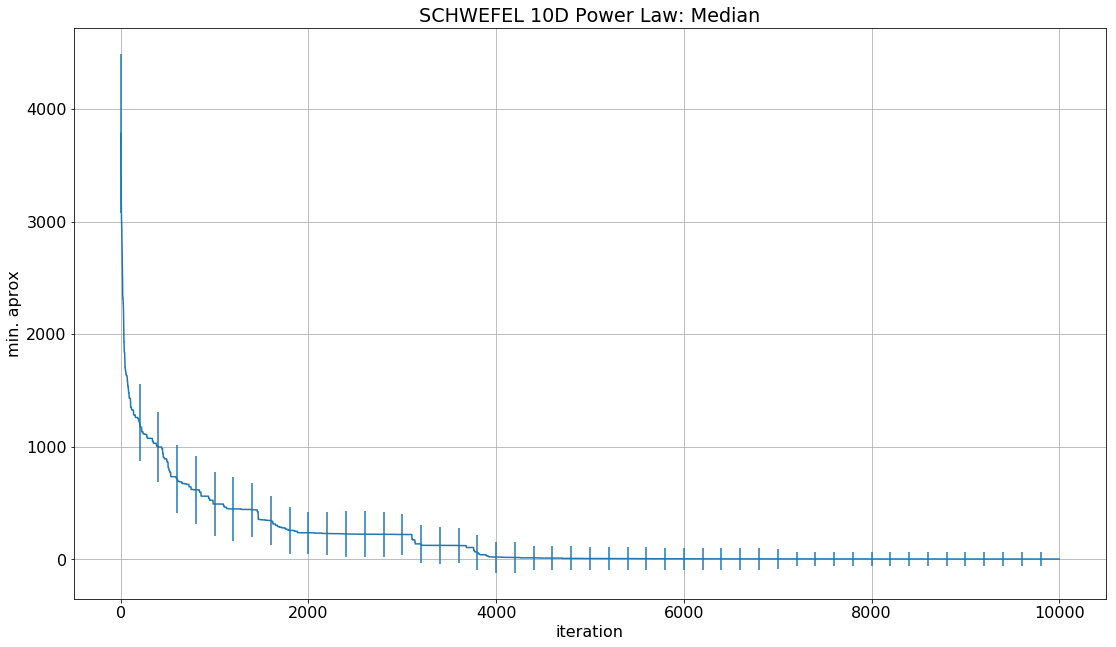

In [340]:
Best_List = []
valVectorSize = 10

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=100, high=500, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm = min_SchwefelPowerLaw(fevalRdm, x1 = 200, x0 = 0.7, alpha = -1.5)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))
print(fevalRdm)


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 10D Power Law => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('schwefelPowerLaw_10d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 10D Power Law: Median")
plt.grid()
plt.savefig('schwefelPowerLawStd_10d.pdf', format='pdf')
plt.show()

# min_Schwefel Hill Climbing
## 2D

 Iteration 29

mean: 20.051482537542093
std: 53.72475135278542
median: 0.3801511266690909
min: 0.00022932620561277872
max: 237.10923393453413
[[421.32822811]
 [421.41929447]]


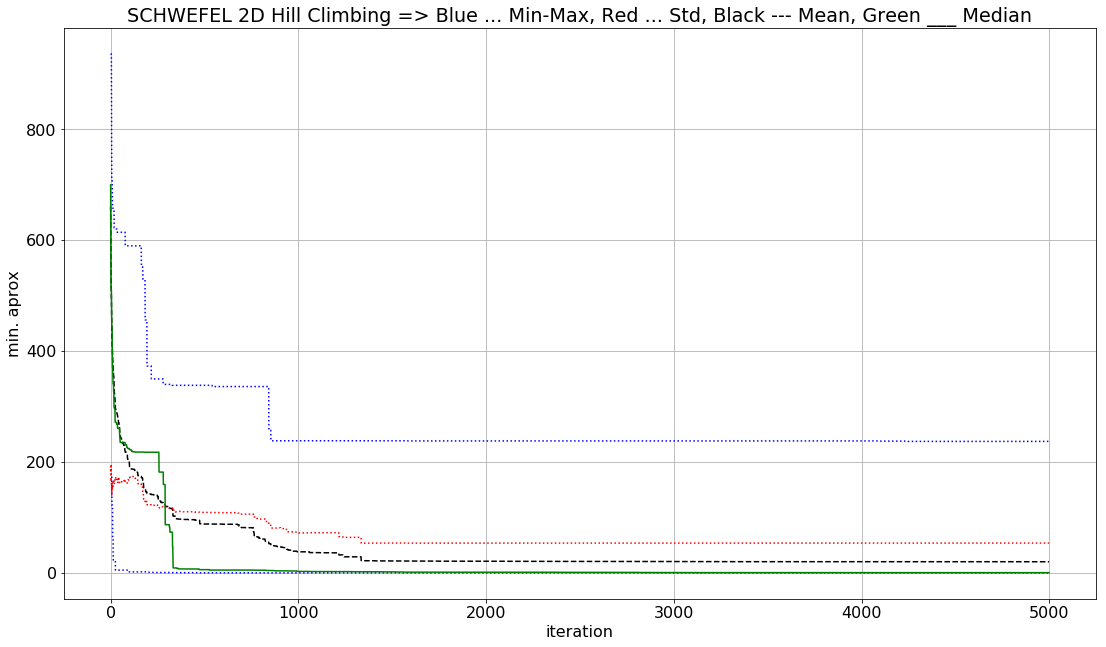

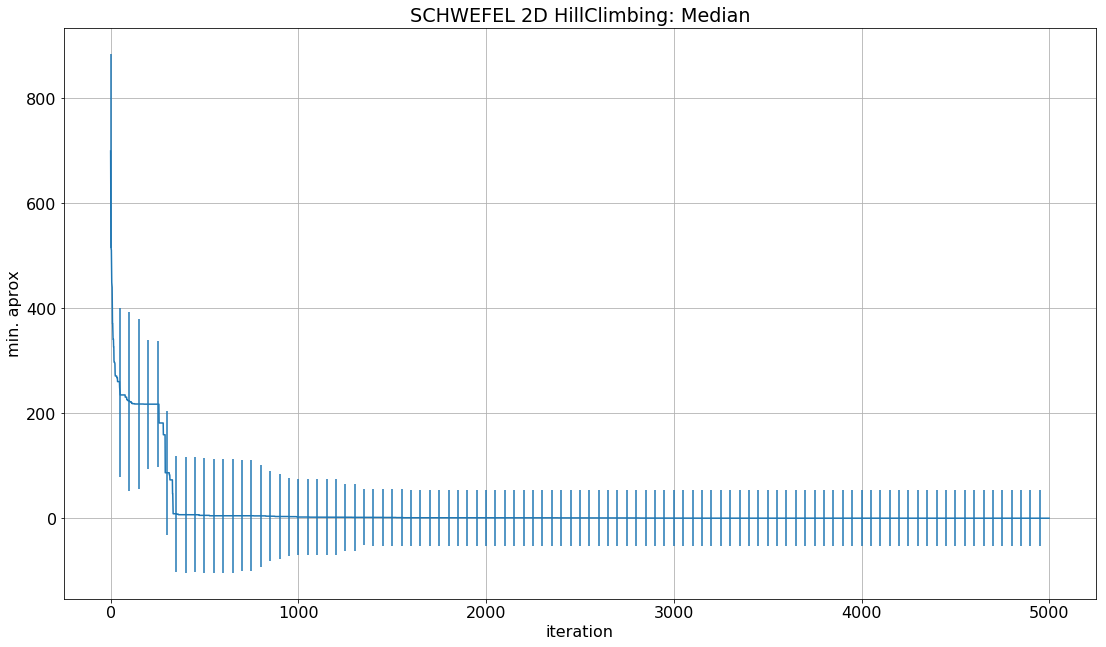

In [341]:
Best_List = []
valVectorSize = 2

if valVectorSize == 2:
    iterSize = 5000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=100, high=500, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm = min_SchwefelHill(fevalRdm,sigma = 70)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))
print(fevalRdm)


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 2D Hill Climbing => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('schwefelHillClimbing_2d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:50] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 2D HillClimbing: Median")
plt.grid()
plt.savefig('schwefelHillClimbingStd_2d.pdf', format='pdf')
plt.show()

# min_Schwefel Hill Climbing
## 10D

 Iteration 29

mean: 1368.9130851150185
std: 289.95209975157087
median: 1356.105124564189
min: 991.5681992160694
max: 2098.7310798484914


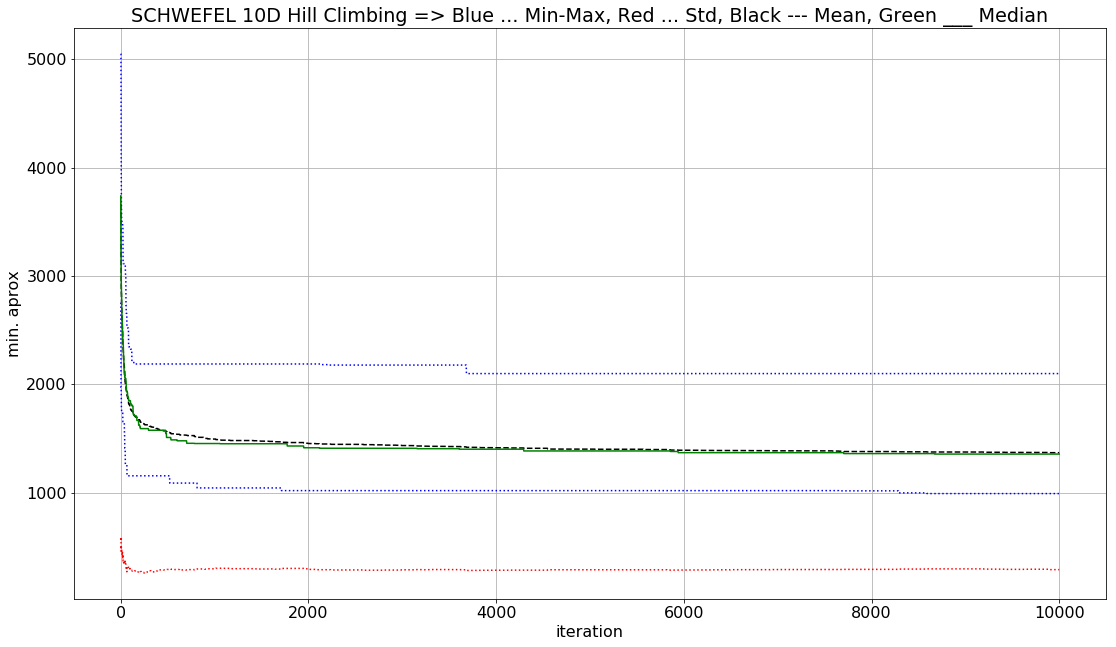

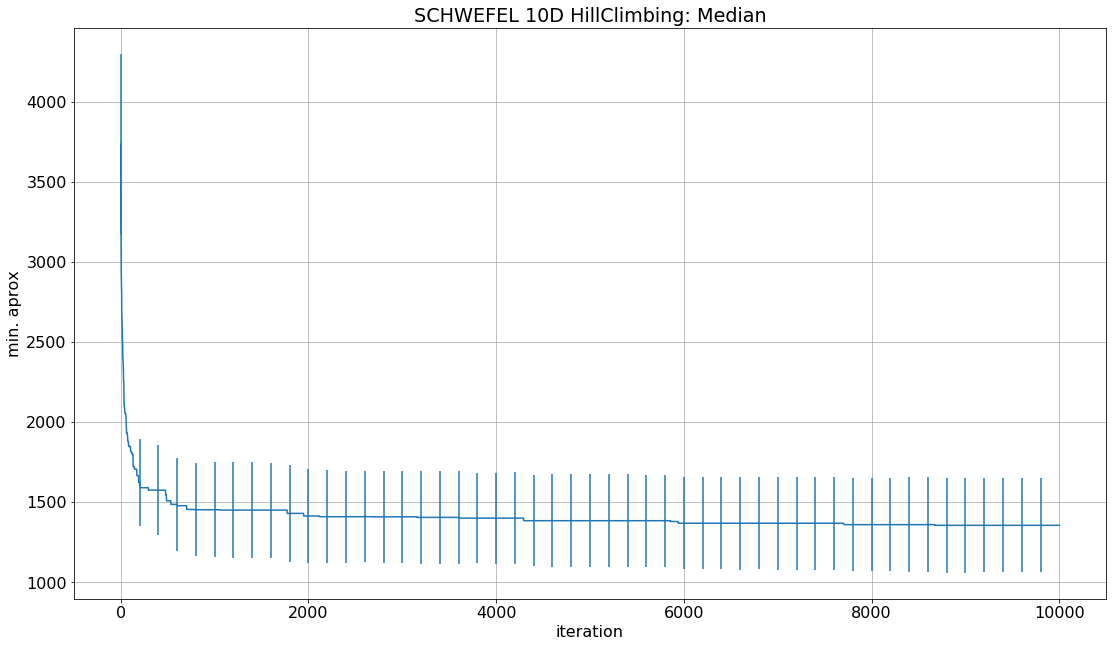

In [367]:
Best_List = []
valVectorSize = 10

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=100, high=500, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm = min_SchwefelHill(fevalRdm,sigma = 35)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))



# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 10D Hill Climbing => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('schwefelHillClimbing_10d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 10D HillClimbing: Median")
plt.grid()
plt.savefig('schwefelHillClimbingStd_10d.pdf', format='pdf')
plt.show()

# min_Schwefel Gradiente
## 2D

 Iteration 29

mean: 223.7232108396732
std: 174.88785052725532
median: 217.1398741857692
min: 0.00010159431667489116
max: 572.488581378097


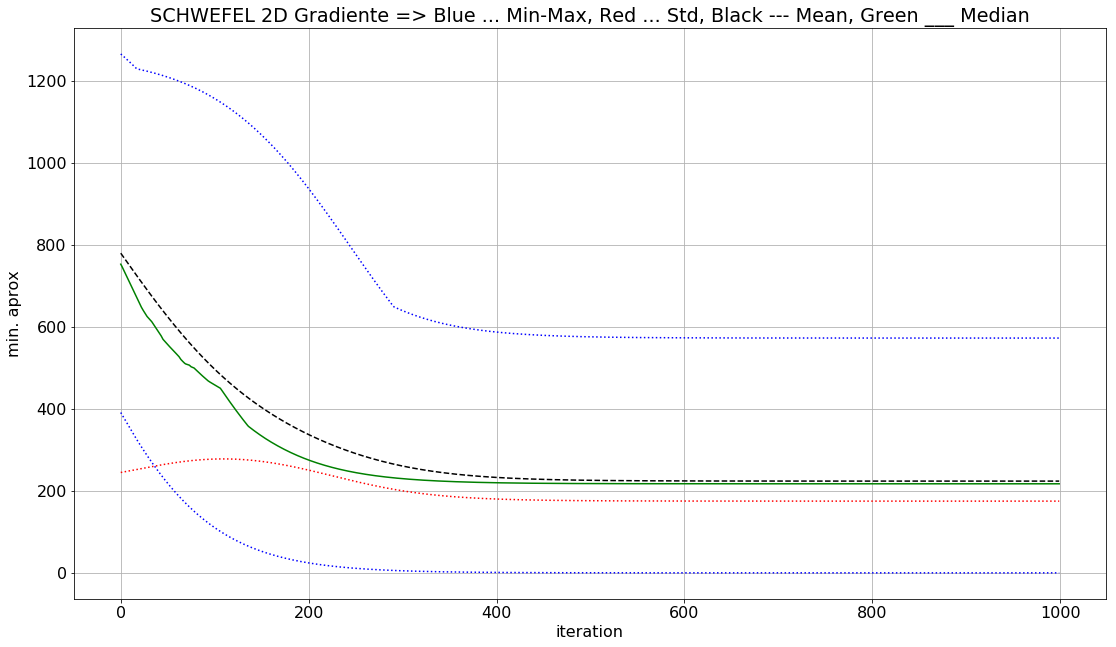

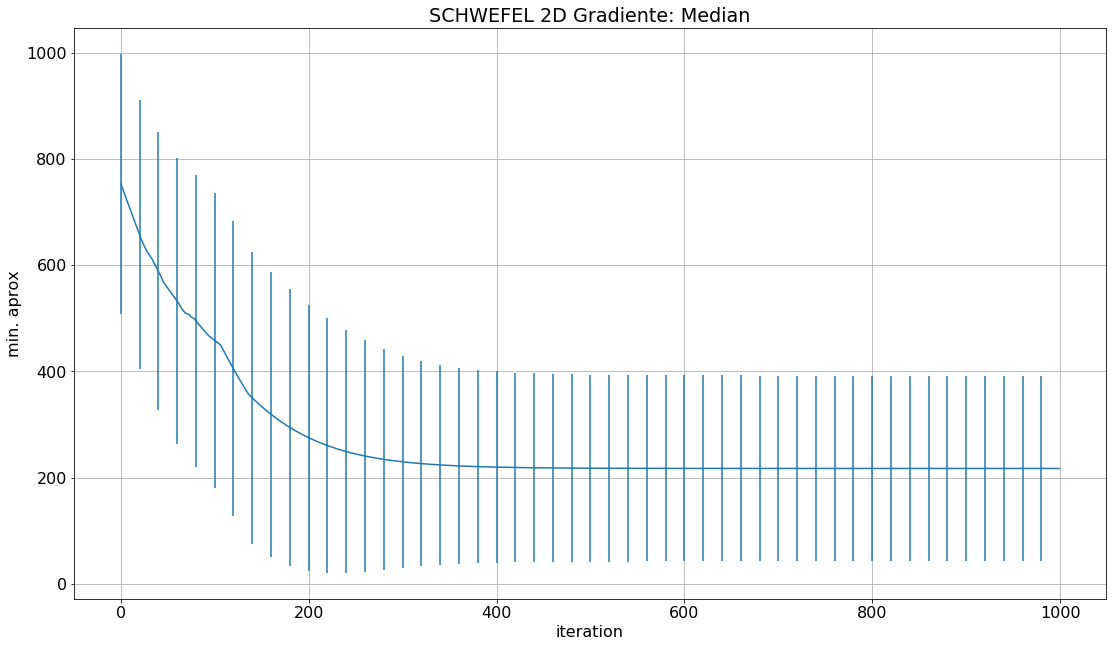

In [382]:
Best_List = []
valVectorSize = 2

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=100, high=500, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm, delta = min_SchwefelGradient(fevalRdm,delta,alpha = 0.025, miu = 0.2)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))



# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 2D Gradiente => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('schwefelGradiente_2d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:20] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 2D Gradiente: Median")
plt.grid()
plt.savefig('schwefelGradienteStd_2d.pdf', format='pdf')
plt.show()

# min_Schwefel Gradiente
## 10D

 Iteration 2

mean: 796.1789150410968
std: 270.8207493122962
median: 868.5588048379541
min: 434.2794660568088
max: 1085.6984742285276


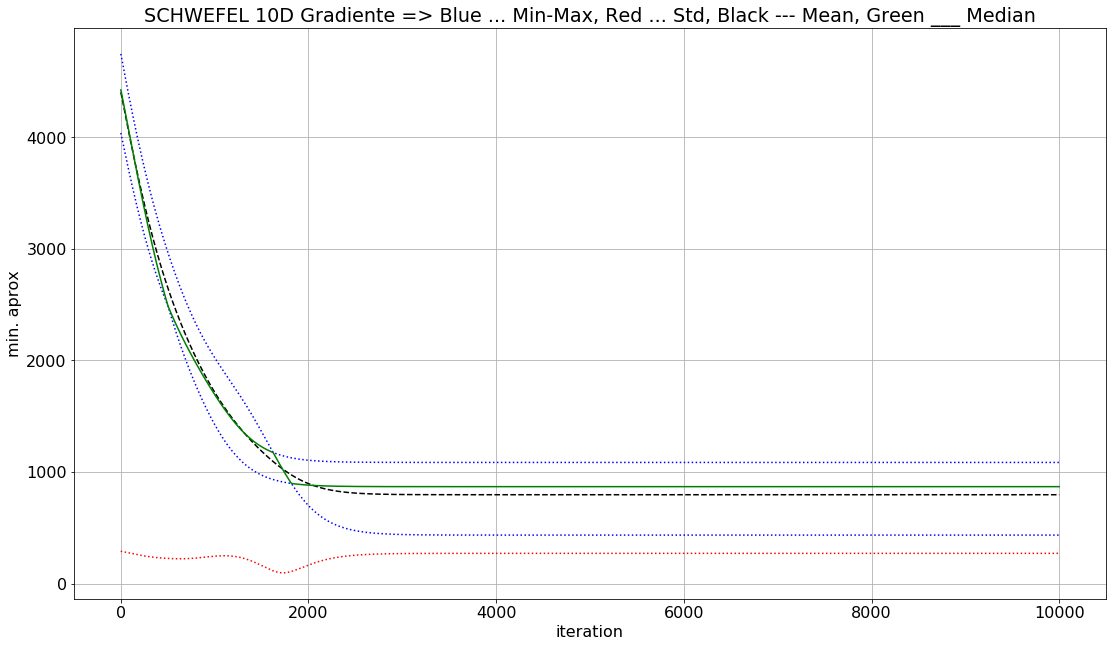

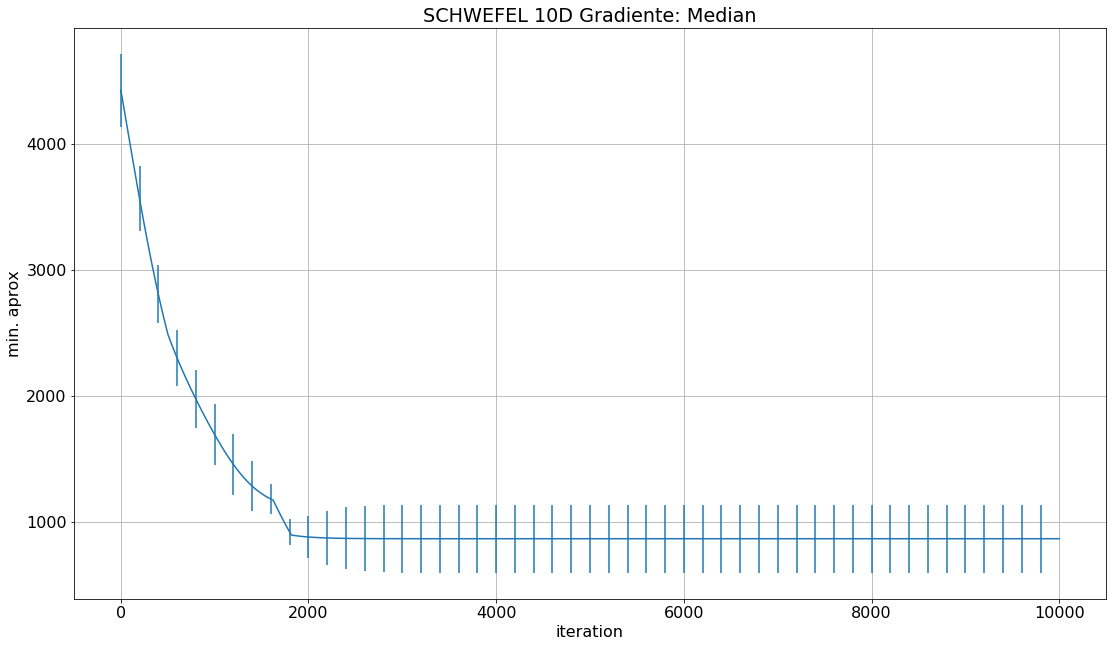

In [388]:
Best_List = []
valVectorSize = 10

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 3
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=100, high=500, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm, delta = min_SchwefelGradient(fevalRdm,delta,alpha = 0.0025, miu = 0.7)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))



# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 10D Gradiente => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('schwefelGradiente_10d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 10D Gradiente: Median")
plt.grid()
plt.savefig('schwefelGradienteStd_10d.pdf', format='pdf')
plt.show()

# min_Schwefel Simulated annealing + Power Law
## 2D

 Temperature 1.3564461456979993

mean: 46.00043057973515
std: 64.12824934630807
median: 1.9576815395049039
min: 0.025660941239834756
max: 237.26579116476864


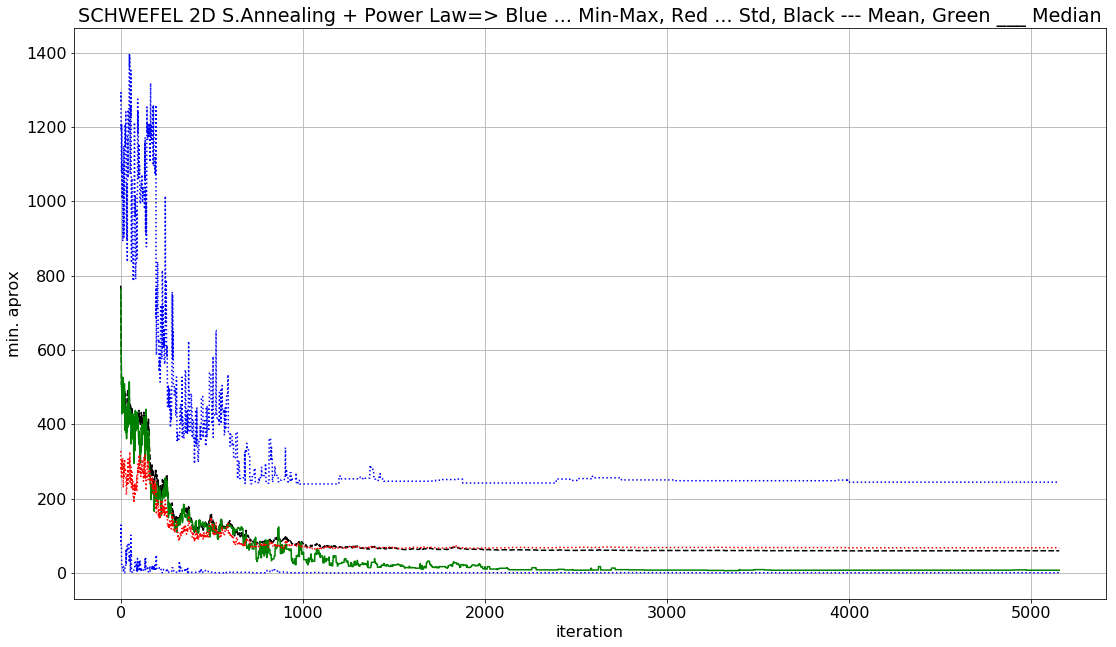

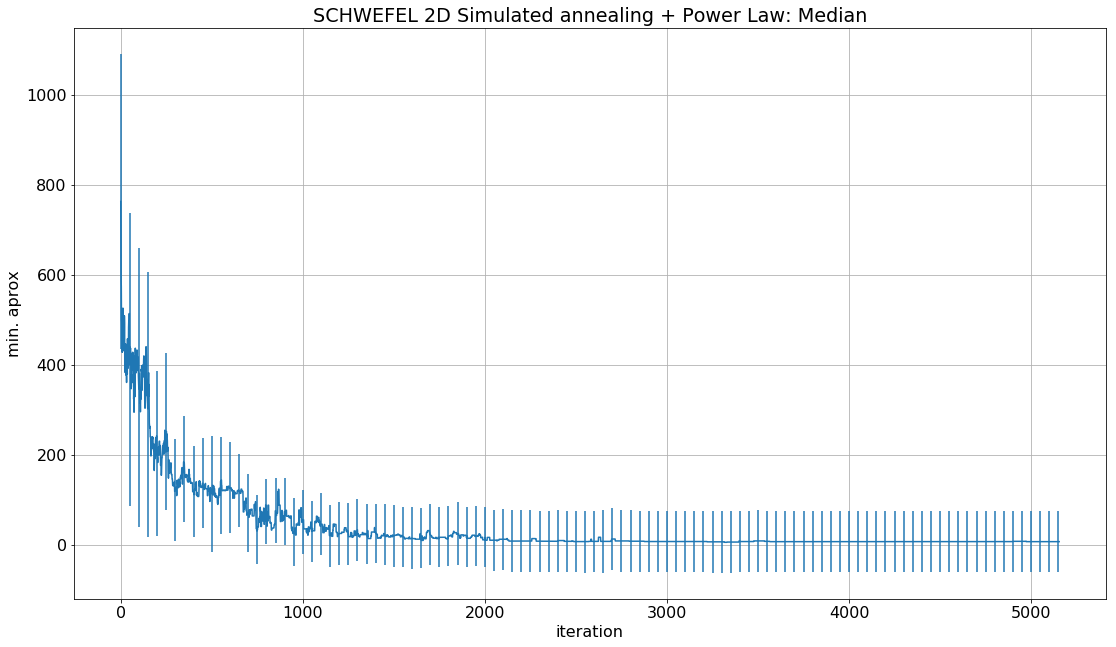

In [393]:
Best_List = []
valVectorSize = 2

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 15
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = None
OutIniFlag = False

tf = lambda t: 0.7*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

for j in range(0, repetitions):
    fevalRdm =  np.random.uniform(low=100, high=500, size=(valVectorSize, 1))
    inits=dict(solution=fevalRdm, length=70, T=200)
    OUT_List_Simanneal_Tmp = []
    bmeta, bs, be, out, OUT_List_Simanneal, Iterations = sa(Schwefel,
                                                                inits,
                                                                SimannealItrSize,
                                                                tf,
                                                                itf,
                                                                'rdmSimetricPoerLow',
                                                                sigma = 0.75,
                                                                x1 = 200,
                                                                x0 = 10,
                                                                alpha = -1.5)
    
    
    Best_List.append(be)
    if OutIniFlag == False:
        OutIniFlag = True
        OUT_Matrix = np.asarray(OUT_List_Simanneal).reshape(1,-1)
    else:
        OUT_Matrix = np.concatenate((OUT_Matrix, np.asarray(OUT_List_Simanneal).reshape(1,-1)), axis=0)



print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 2D S.Annealing + Power Law=> Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('schwefelSAnnealPlw_2d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:50] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 2D Simulated annealing + Power Law: Median")
plt.grid()
plt.savefig('schwefelSAnnealPlwStd_2d.pdf', format='pdf')
plt.show()






# min_Schwefel Simulated annealing + Power Law
## 10D

 Temperature 0.9007199254741001

mean: 72.9030242648775
std: 89.67759840508702
median: 2.644122900597722
min: 0.807573933245294
max: 357.015491171921


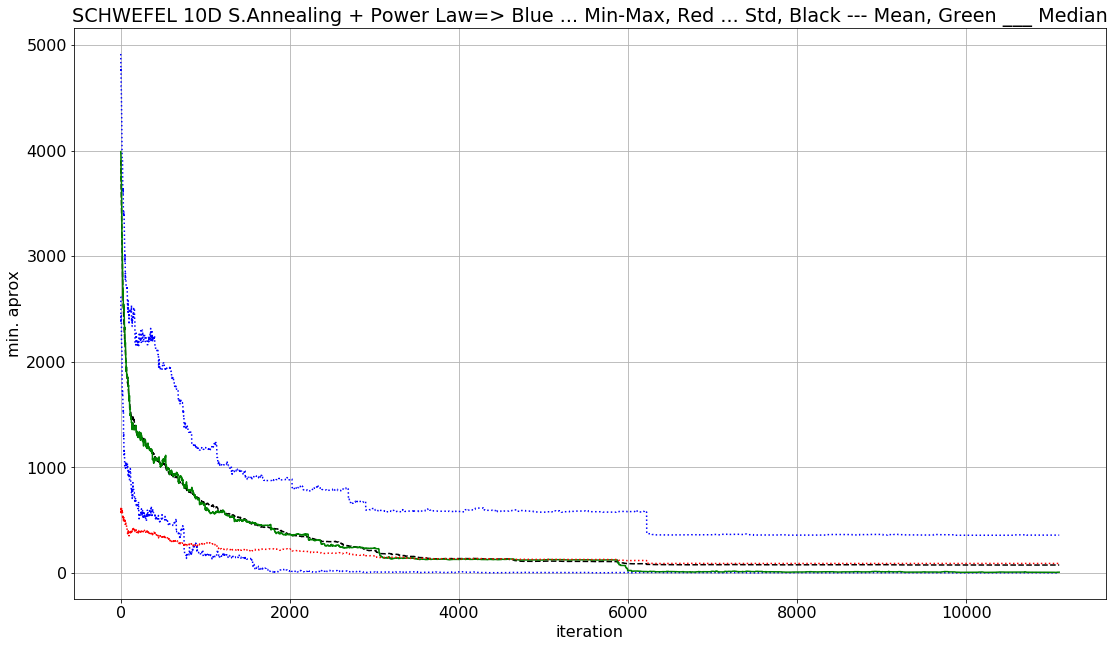

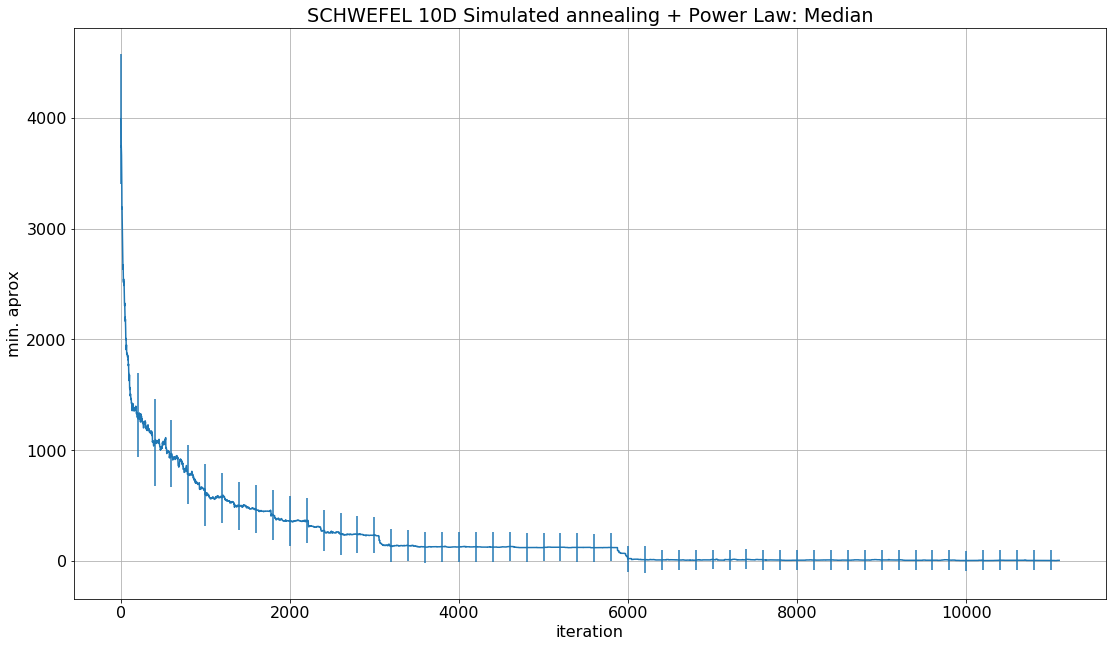

In [432]:
Best_List = []
valVectorSize = 10

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 15
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = None
OutIniFlag = False

tf = lambda t: 0.8*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

for j in range(0, repetitions):
    fevalRdm =  np.random.uniform(low=100, high=500, size=(valVectorSize, 1))
    inits=dict(solution=fevalRdm, length=70, T=50)
    OUT_List_Simanneal_Tmp = []
    bmeta, bs, be, out, OUT_List_Simanneal, Iterations = sa(Schwefel,
                                                                inits,
                                                                SimannealItrSize,
                                                                tf,
                                                                itf,
                                                                'rdmSimetricPoerLow',
                                                                sigma = 0.75,
                                                                x1 = 287,
                                                                x0 = 1,
                                                                alpha = -2)
    
    
    Best_List.append(be)
    if OutIniFlag == False:
        OutIniFlag = True
        OUT_Matrix = np.asarray(OUT_List_Simanneal).reshape(1,-1)
    else:
        OUT_Matrix = np.concatenate((OUT_Matrix, np.asarray(OUT_List_Simanneal).reshape(1,-1)), axis=0)



print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 10D S.Annealing + Power Law=> Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('schwefelSAnnealPlw_10d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 10D Simulated annealing + Power Law: Median")
plt.grid()
plt.savefig('schwefelSAnnealPlwStd_10d.pdf', format='pdf')
plt.show()







# min_Schwefel Simulated annealing + Normal
## 2D

 Temperature 16.470869999999998

mean: 69.06512944726491
std: 59.35765642037077
median: 50.570983610563644
min: 0.5289857116914618
max: 200.52491263693287


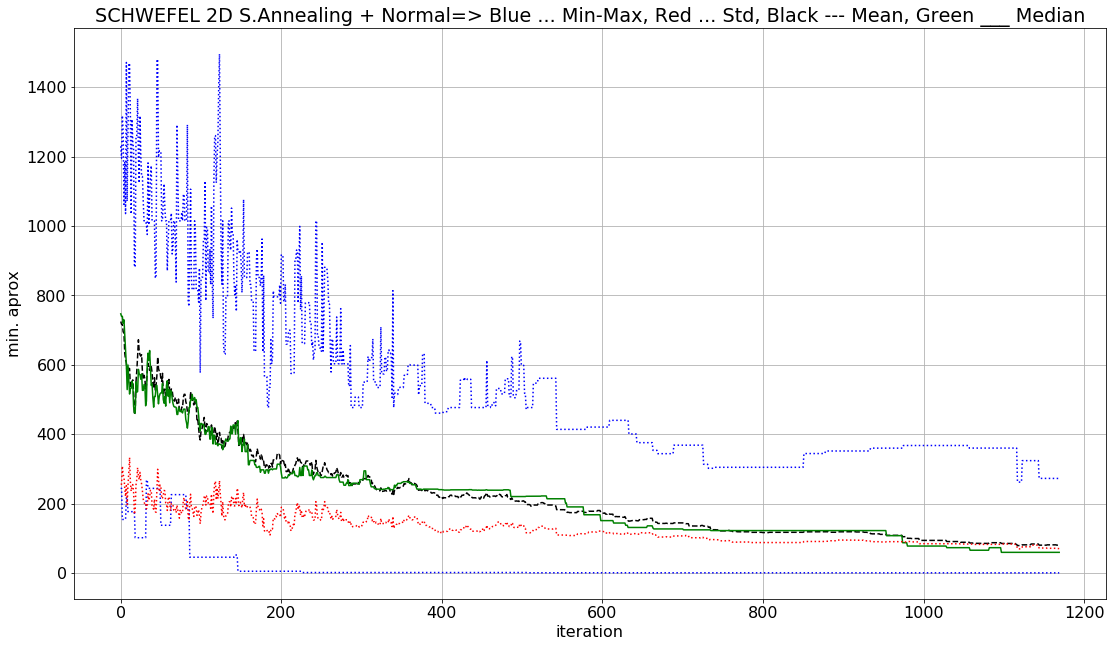

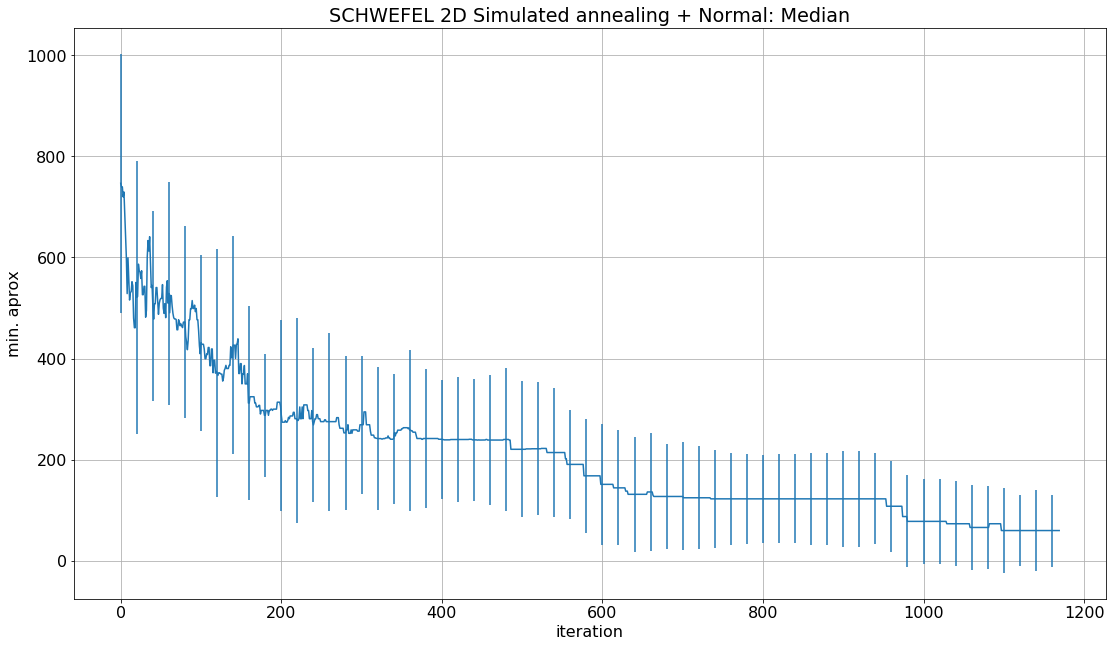

In [462]:
Best_List = []
valVectorSize = 2

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = None
OutIniFlag = False

tf = lambda t: 0.7*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

for j in range(0, repetitions):
    fevalRdm =  np.random.uniform(low=100, high=500, size=(valVectorSize, 1))
    inits=dict(solution=fevalRdm, length=70, T=200)
    
    bmeta, bs, be, out, OUT_List_Simanneal, Iterations = sa(Schwefel,
                                                                inits,
                                                                SimannealItrSize,
                                                                tf,
                                                                itf,
                                                                'rdmGauss',
                                                                sigma = 400,
                                                                x1 = 20,
                                                                x0 = 0.5,
                                                                alpha = -1.5)
    
    
    Best_List.append(be)
    if OutIniFlag == False:
        OutIniFlag = True
        OUT_Matrix = np.asarray(OUT_List_Simanneal).reshape(1,-1)
    else:
        OUT_Matrix = np.concatenate((OUT_Matrix, np.asarray(OUT_List_Simanneal).reshape(1,-1)), axis=0)



print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 2D S.Annealing + Normal=> Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('schwefelSAnnealNrm_2d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:20] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 2D Simulated annealing + Normal: Median")
plt.grid()
plt.savefig('schwefelSAnnealNrmStd_2d.pdf', format='pdf')
plt.show()







# min_Schwefel Simulated annealing + Normal
## 10D

 Temperature 36.773185647764805

mean: 1028.16972047618
std: 343.2018228332378
median: 1053.03778863515
min: 227.03684161690035
max: 1731.6933066167585


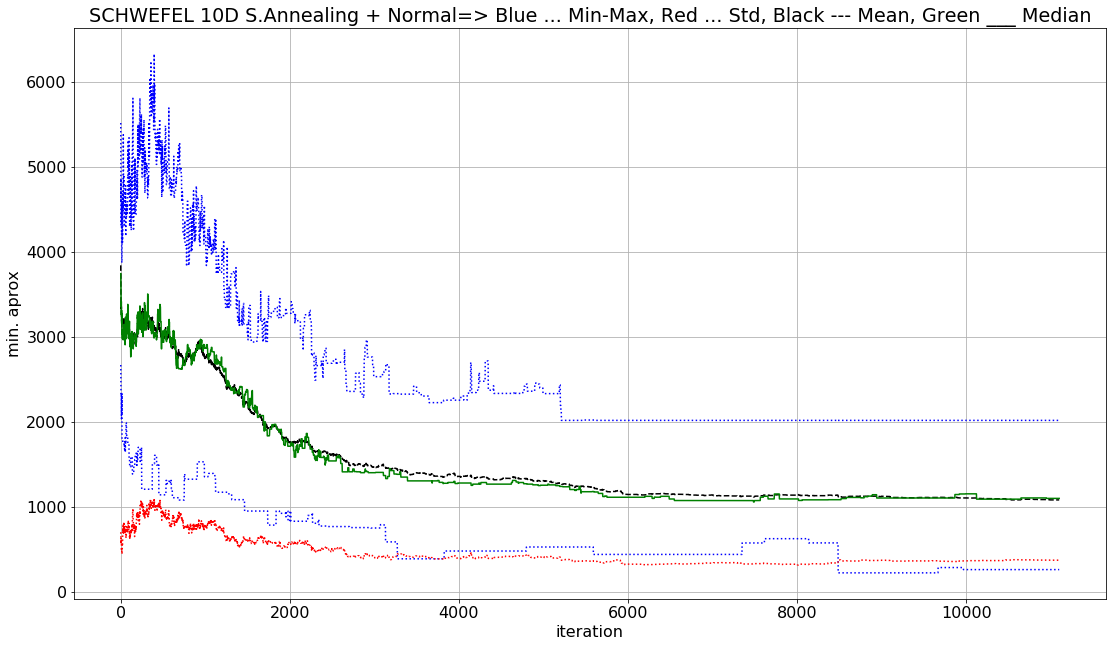

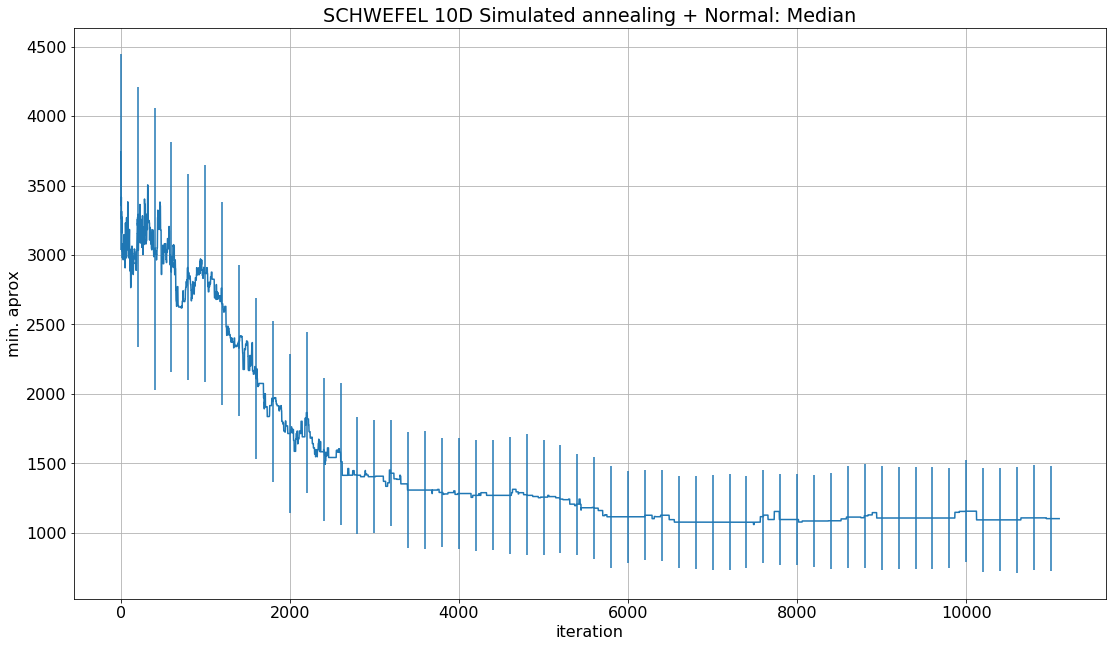

In [469]:
Best_List = []
valVectorSize = 10

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = None
OutIniFlag = False

tf = lambda t: 0.9*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

for j in range(0, repetitions):
    fevalRdm =  np.random.uniform(low=100, high=500, size=(valVectorSize, 1))
    inits=dict(solution=fevalRdm, length=70, T=245)
    
    bmeta, bs, be, out, OUT_List_Simanneal, Iterations = sa(Schwefel,
                                                                inits,
                                                                SimannealItrSize,
                                                                tf,
                                                                itf,
                                                                'rdmGauss',
                                                                sigma = 41.36,
                                                                x1 = 20,
                                                                x0 = 0.5,
                                                                alpha = -1.5)
    
    
    Best_List.append(be)
    if OutIniFlag == False:
        OutIniFlag = True
        OUT_Matrix = np.asarray(OUT_List_Simanneal).reshape(1,-1)
    else:
        OUT_Matrix = np.concatenate((OUT_Matrix, np.asarray(OUT_List_Simanneal).reshape(1,-1)), axis=0)



print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 10D S.Annealing + Normal=> Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('schwefelSAnnealNrm_10d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("SCHWEFEL 10D Simulated annealing + Normal: Median")
plt.grid()
plt.savefig('schwefelSAnnealNrmStd_10d.pdf', format='pdf')
plt.show()








In [276]:

for i in range(20):
    print(rdmSimetricPoerLow(x1 = 200, x0 = 10, alpha = -1.5))

-28.10944417670055
12.190669932714094
151.8028029605285
-48.98985321354414
16.079620523035075
63.76192346405701
-80.87692865466641
-20.18198108550659
22.853616432352105
18.313084087332644
-30.83347020180569
13.931574675390491
-24.581229774121713
-28.181456215817178
86.84348226855901
-32.62756334492509
33.258640189226625
-38.85751595424582
-10.16432838604282
18.415243952385293


[[0 1 0 1]
 [0 1 1 1]
 [1 0 0 0]
 ...
 [0 0 1 0]
 [1 1 0 1]
 [0 0 1 1]]


<function matplotlib.pyplot.show(*args, **kw)>

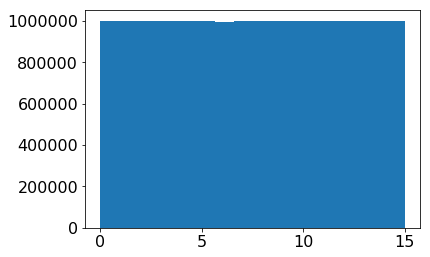

In [272]:
def populationGen(N=100,d = 10):
    return np.random.randint(2, size=(N, d))
   

Pop = populationGen(N=16000000,d =4)
print(Pop)

disitr = []

for i in range(Pop.shape[0]):
    disitr.append((Pop[i][0] + Pop[i][1]*2 + Pop[i][2]*4  + Pop[i][3]*8))
    
    
plt.hist(disitr,bins=16)
plt.show

In [255]:
print(np.random.randint(2, size=10)[0])
"""
for a in range(10):
    out = np.random.randint(2, size=1)[0] + np.random.randint(2, size=1)[0]*2  + np.random.randint(2, size=1)[0]*4   + np.random.randint(2, size=1)[0]*8
    print(out)
"""


0


'\nfor a in range(10):\n    out = np.random.randint(2, size=1)[0] + np.random.randint(2, size=1)[0]*2  + np.random.randint(2, size=1)[0]*4   + np.random.randint(2, size=1)[0]*8\n    print(out)\n'

In [965]:
# import mygabasic as ga
# from mygabasic import pGenerator
# import mygabasic
# mygabasic.__name__
# Pop = ga.pgenerator(N=160,d =4)
help(ga)

HOlA MYGABASIC
Help on module mygabasic:

NAME
    mygabasic - module(name[, doc])

DESCRIPTION
    Create a module object.
    The name must be a string; the optional doc argument can have any type.

FUNCTIONS
    gcoding(val=0, minVal=-5.12, maxVal=5.12, codeLen=16)
        # Generate val binary code list
    
    gdeco(bitlist=0, minVal=-5.12, maxVal=5.12, codeLen=16)
        # Generate val from bin lint
    
    pgenerator(N=100, d=10)
        # Generate population
    
    popAscOrd(fitList=0, fitVal=0, pop=0)
        # Return ascendent ordered pop
    
    popfitnes(pop=0, minVal=-5.12, maxVal=5.12, codeLen=16, genQty=2, funct=None)
        # Workout fitness

FILE
    /Users/SerG1oAC/Documents/EvolutiveComputing/notebook/mygabasic.py




In [862]:

"""
print(Pop)
splitPop = Pop.reshape((8,-1,16))
print(splitPop.shape)
lalout = np.zeros((8,2))
index = 0
for dimSet in splitPop:
    valOut = [ga.gdeco(bitlist = dim, minVal = 100, maxVal = 500, codeLen = 16) for dim in dimSet]
    lalout[index] = valOut
    index = index + 1

print(lalout)
fevalRdm =  np.random.uniform(low=100, high=500, size=(2, 1))
print(fevalRdm.shape)
fitList = [Schwefel(np.expand_dims(varOut, axis=-1)) for varOut in lalout]
print(fitList)
"""

    

HOlA MYGABASIC


'\nprint(Pop)\nsplitPop = Pop.reshape((8,-1,16))\nprint(splitPop.shape)\nlalout = np.zeros((8,2))\nindex = 0\nfor dimSet in splitPop:\n    valOut = [ga.gdeco(bitlist = dim, minVal = 100, maxVal = 500, codeLen = 16) for dim in dimSet]\n    lalout[index] = valOut\n    index = index + 1\n\nprint(lalout)\nfevalRdm =  np.random.uniform(low=100, high=500, size=(2, 1))\nprint(fevalRdm.shape)\nfitList = [Schwefel(np.expand_dims(varOut, axis=-1)) for varOut in lalout]\nprint(fitList)\n'

In [1327]:
# Generate population
Pop = ga.pgenerator(N=8,d =32)
print(Pop)
# Workout population fitness
fitList,fitVal = ga.popfitnes(pop = Pop,minVal = 100, maxVal = 500, codeLen = 16, genQty = 2, funct = Schwefel)
print(fitVal)
print(fitList)


[[0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 1 1]
 [0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1]
 [1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1 1 0 1]
 [1 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1]
 [1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0]
 [0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 0 1]
 [0 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1]
 [1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1]]
[[173.1731136  354.9813077 ]
 [195.13389792 488.72358282]
 [438.33829252 417.37239643]
 [455.71526665 308.26428626]
 [380.15259022 452.1934844 ]
 [194.15121691 297.10688945]
 [223.00907912 102.84122988]
 [453.7987335  190.68436713]]
[744.2212641291981, 702.1216576138962, 39.383547690140176, 860.8485110944466, 308.21697535348096, 944.6602619053717, 749.5309740063724, 369.09830921469427]


In [1329]:
pselect = ga.tournamentSelection(Pop, fitList, 4)
print(pselect)

[[1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0]
 [1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1 1 0 1]
 [1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1]
 [1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0]
 [1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1 1 0 1]
 [1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0]
 [1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1]
 [1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1]]


In [1330]:
ordPop,ordFitVal,ordFitLst,rankWeighting = ga.rankWeighting(fitList,fitVal,Pop,keep = 1)
print(ordPop)
print(ordFitVal)
print(ordFitLst)
print(rankWeighting)


[[1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1 1 0 1]
 [1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0]
 [1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1]
 [0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1]
 [0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 1 1]
 [0 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1]
 [1 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1]
 [0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 0 1]]
[[438.33829252 417.37239643]
 [380.15259022 452.1934844 ]
 [453.7987335  190.68436713]
 [195.13389792 488.72358282]
 [173.1731136  354.9813077 ]
 [223.00907912 102.84122988]
 [455.71526665 308.26428626]
 [194.15121691 297.10688945]]
[ 39.38354769 308.21697535 369.09830921 702.12165761 744.22126413
 749.53097401 860.84851109 944.66026191]
[0.22222222 0.41666667 0.58333333 0.72222222 0.83333333 0.91666667
 0.97222222 1.        ]


In [1331]:
pselect = ga.weightedSelection(ordPop, rankWeighting, 4)
print(pselect)

[[0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1]
 [1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1]
 [0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1]
 [1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1 1 0 1]
 [1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0]
 [1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1]
 [1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0]
 [1 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1]]


In [1332]:
ordPop,ordFitVal,ordFitLst,costWeighting = ga.costWeighting(fitList,fitVal,Pop,keep = 1)
print(ordPop)
print(ordFitVal)
print(ordFitLst)
print(costWeighting)

[[1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1 1 0 1]
 [1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0]
 [1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1]
 [0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1]
 [0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 1 1]
 [0 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1]
 [1 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1]
 [0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 0 1]]
[[438.33829252 417.37239643]
 [380.15259022 452.1934844 ]
 [453.7987335  190.68436713]
 [195.13389792 488.72358282]
 [173.1731136  354.9813077 ]
 [223.00907912 102.84122988]
 [455.71526665 308.26428626]
 [194.15121691 297.10688945]]
[ 39.38354769 308.21697535 369.09830921 702.12165761 744.22126413
 749.53097401 860.84851109 944.66026191]
[0.27809806 0.48141483 0.66779627 0.76154072 0.84357434 0.92413096
 0.97372242 1.        ]


In [1357]:
pselect = ga.weightedSelection(ordPop, costWeighting, 4)
print(pselect)

HOlA MYGABASIC
[[0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 1 1]
 [0 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 1 1]
 [0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1]
 [1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0]
 [1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0]
 [0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1]
 [1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0]
 [1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1]]


In [1360]:
children = ga.childenGen(pselect, matingPercent = 0.7, mutaPercent = 0.03)
print(children.dtype)
print(children)

uint8
[[0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1]
 [0 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 1 1]
 [0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1]
 [1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0]
 [1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1]
 [0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0]
 [1 0 1 1 0 0 1 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1]
 [1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 1 0 1 1 0 0 1 0 1]]


In [1318]:
crossover_point = np.random.randint((pselect.shape[1] - 1))
print(crossover_point)

outl = np.append(pselect[6][0:(crossover_point + 1)], pselect[7][crossover_point + 1:])
print(outl)
out2 = np.append(pselect[7][0:(crossover_point + 1)], pselect[6][crossover_point + 1:])
print(out2)

HOlA MYGABASIC
1
[1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1]
[0 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0]


In [1319]:
mup = np.random.uniform(0,1,32)
print(mup)
mask = ((1-0.03) <= mup).astype(np.uint8)
print(out2)
print(mask)
mutate = np.where( mask == 1)
print(out2[mutate[0]])
mutation = np.logical_not(out2[mutate[0]]).astype(np.uint8)
print(mutation)
out2[mutate[0]] = mutation
print(out2)

[0.36112678 0.00216091 0.55169017 0.10050743 0.98848339 0.3635873
 0.05448513 0.86383541 0.46633051 0.19315293 0.57261211 0.63333024
 0.19976668 0.786936   0.20285343 0.1570194  0.67004602 0.99504592
 0.56160914 0.11324763 0.83432797 0.13161913 0.1640667  0.52306521
 0.64135394 0.62009997 0.63023532 0.11652921 0.73879615 0.05126241
 0.44825904 0.53862779]
[0 1 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0]
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0]
[1 1]
[0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0]


# Genetic Algorithms

## schwefelTournamentGA_2d.pdf

 Iteration 999

Last fit info______
Last fit mean: 31.534471787934322
Last fit std: 77.43342754886818
Last fit median: 9.295192796798801e-05
Last fit min: 2.5897774094119086e-05
Last fit max: 285.66820762422765
Last Pop info______
Last Pop mean: [421.82803082 409.55252918]
Last Pop std: [ 9.37032171 49.13302097]
Last Pop median: [420.96742199 420.96742199]
Last Pop min: [408.46723125 220.96437018]
Last Pop max: [471.06584268 445.96780346]


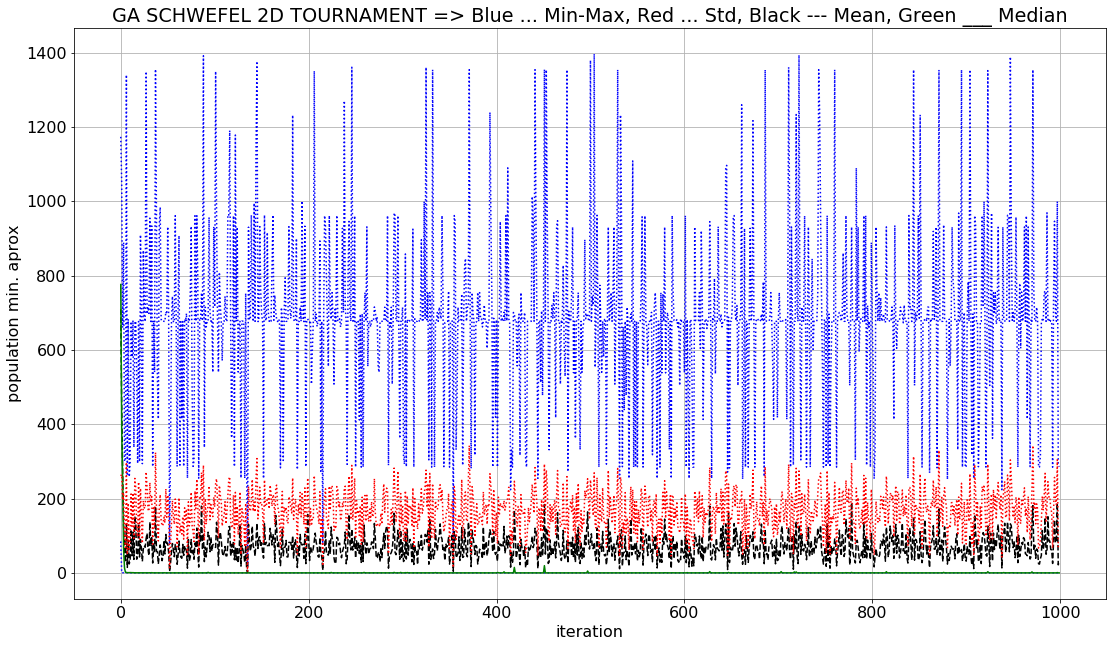

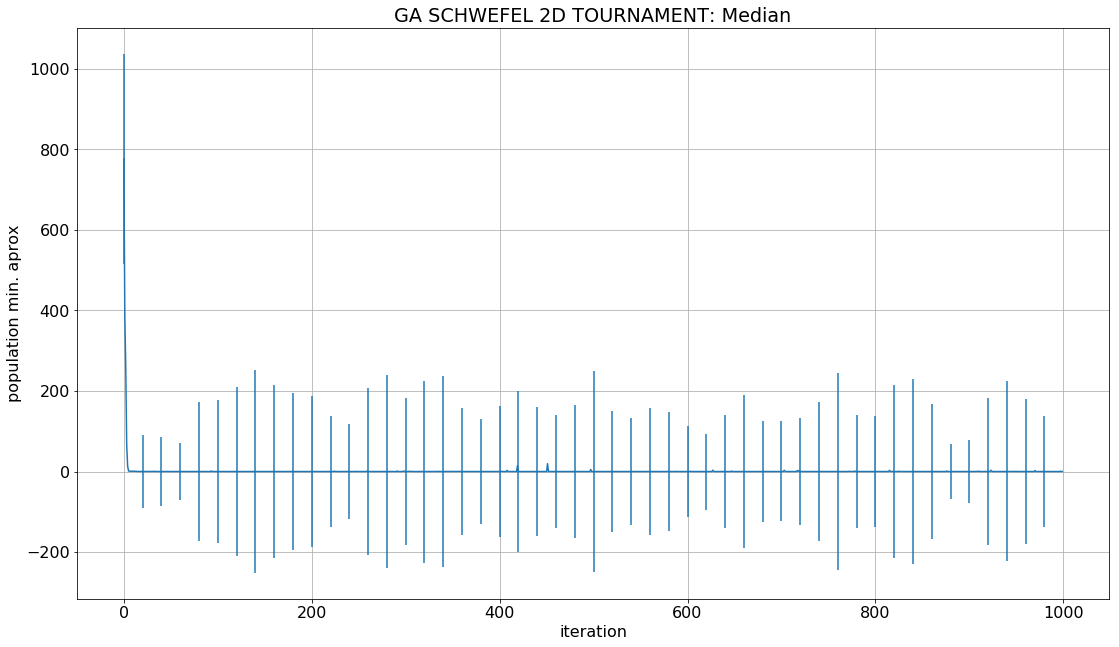

In [1420]:
# Generate population
N = 32
minVal = 100
maxVal = 500
codeLen = 16
genQty = 2
d = codeLen * genQty
iterations = 1000
matingPercent = 0.7
mutaPercent = 0.04
# Initial population
Pop = ga.pgenerator(N=N,d =d)
# Evolving output matrix
OUT_Matrix = np.zeros((5, iterations))
Iterations = []


for i in range(iterations):
    sys.stdout.write("\r Iteration " + str(i))
    sys.stdout.flush()
    Iterations.append(i)
    # Workout population fitness
    fitList,fitVal = ga.popfitnes(pop = Pop,minVal = minVal, maxVal = maxVal, codeLen = codeLen, genQty = genQty, funct = Schwefel)

    OUT_Matrix[0][i] = np.mean(fitList)
    OUT_Matrix[1][i] = np.median(fitList)
    OUT_Matrix[2][i] = np.max(fitList)
    OUT_Matrix[3][i] = np.min(fitList)
    OUT_Matrix[4][i] = np.std(fitList)
    pselect = ga.tournamentSelection(Pop, fitList, int(N/2))
    if i == (iterations - 1):
        # in last iteration children are equal to parents
        matingPercent = -1   
    children = ga.childenGen(pselect, matingPercent = matingPercent, mutaPercent = mutaPercent)
    Pop = children
    
# Last populatio fitness
print('\n')
print('Last fit info______')
print('Last fit mean: ' + str(np.mean(fitList)))
print('Last fit std: ' + str(np.std(fitList)))
print('Last fit median: ' + str(np.median(fitList)))
print('Last fit min: ' + str(np.amin(fitList)))
print('Last fit max: ' + str(np.amax(fitList)))
print('Last Pop info______')
print('Last Pop mean: ' + str(np.mean(fitVal, axis=0)))
print('Last Pop std: ' + str(np.std(fitVal, axis=0)))
print('Last Pop median: ' + str(np.median(fitVal, axis=0)))
print('Last Pop min: ' + str(np.amin(fitVal, axis=0)))
print('Last Pop max: ' + str(np.amax(fitVal, axis=0)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[2]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[3]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[0]),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[1]),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[4]),
         'r:',)

plt.ylabel('population min. aprox')
plt.xlabel('iteration')
plt.title("GA SCHWEFEL 2D TOURNAMENT => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('schwefelTournamentGA_2d.pdf', format='pdf')
plt.show()

# Standard Deviation Plot
Ala = OUT_Matrix[4]
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:20] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, OUT_Matrix[1], truncated)
plt.ylabel('population min. aprox')
plt.xlabel('iteration')
plt.title("GA SCHWEFEL 2D TOURNAMENT: Median")
plt.grid()
plt.savefig('schwefelTournamentGAStd_2d.pdf', format='pdf')
plt.show()

## schwefelTournamentGA_10d.pdf

 Iteration 9999

Last fit info______
Last fit mean: 183.7823376375087
Last fit std: 315.4190971982298
Last fit median: 1.484881748470798
Last fit min: 0.7759705136395496
Last fit max: 1436.682709730605
Last Pop info______
Last Pop mean: [416.4855993  414.76024143 420.79545996 414.00600705 416.33763805
 412.29671287 416.4025938  419.73554804 420.83629096 420.40251273]
Last Pop std: [34.45850993 41.12518603 12.34917478 39.77263971 32.7619766  43.92436301
 33.31343715 17.51390636  6.31809132 13.13034017]
Last Pop median: [420.96520943 423.44754711 420.96520943 420.96520943 420.96520943
 420.96520943 420.96520943 420.96520943 420.96520943 420.96520943]
Last Pop min: [175.96147097 178.44380865 298.4633402  145.33600366 176.44747082
 175.96147097 175.96147097 298.4633402  390.10048066 298.4633402 ]
Last Pop max: [482.21614405 431.10391394 482.21614405 482.21614405 482.21614405
 436.2480354  482.21614405 482.21614405 474.55977722 482.22362097]


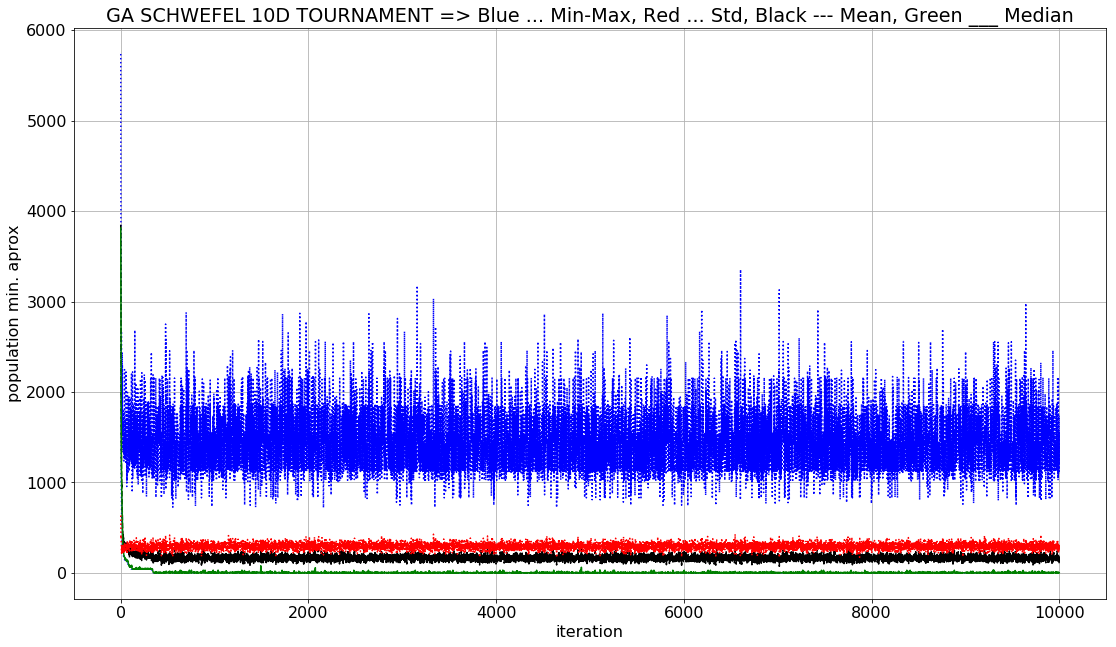

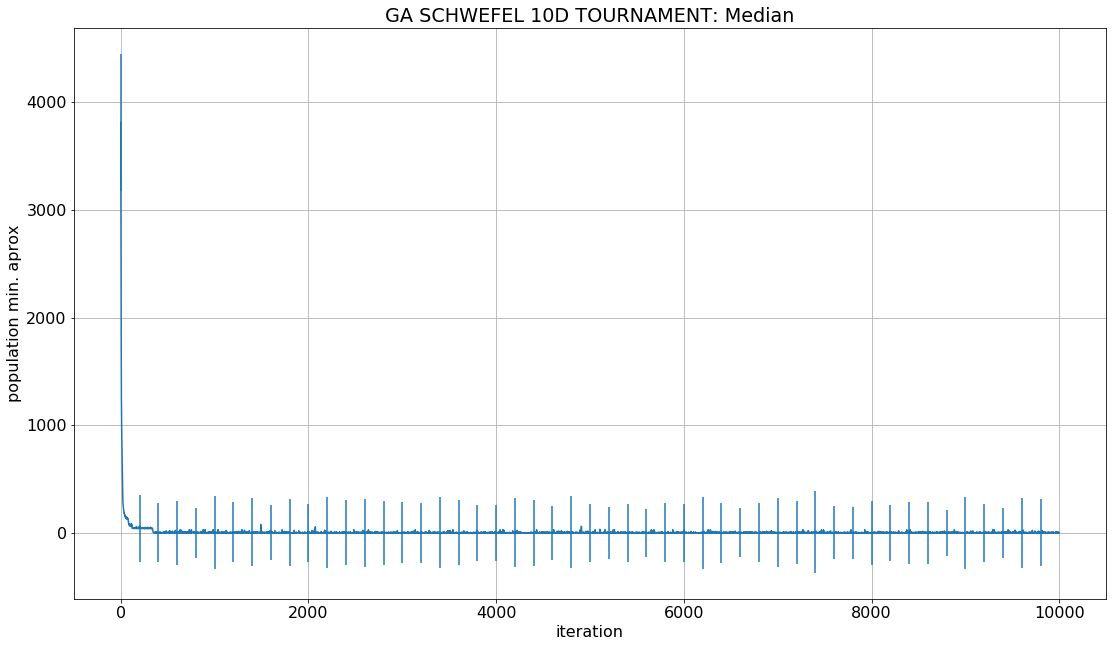

In [1423]:
# Generate population
N = 128
minVal = 10
maxVal = 500
codeLen = 16
genQty = 10
d = codeLen * genQty
iterations = 10000
matingPercent = 0.7
mutaPercent = 0.015
# Initial population
Pop = ga.pgenerator(N=N,d =d)
# Evolving output matrix
OUT_Matrix = np.zeros((5, iterations))
Iterations = []

for i in range(iterations):
    sys.stdout.write("\r Iteration " + str(i))
    sys.stdout.flush()
    Iterations.append(i)
    # Workout population fitness
    fitList,fitVal = ga.popfitnes(pop = Pop,minVal = minVal, maxVal = maxVal, codeLen = codeLen, genQty = genQty, funct = Schwefel)

    OUT_Matrix[0][i] = np.mean(fitList)
    OUT_Matrix[1][i] = np.median(fitList)
    OUT_Matrix[2][i] = np.max(fitList)
    OUT_Matrix[3][i] = np.min(fitList)
    OUT_Matrix[4][i] = np.std(fitList)
    
    pselect = ga.tournamentSelection(Pop, fitList, int(N/2))
    if i == (iterations - 1):
        # in last iteration children are equal to parents
        matingPercent = -1   
    children = ga.childenGen(pselect, matingPercent = matingPercent, mutaPercent = mutaPercent)
    Pop = children
    
# Last populatio fitness
print('\n')
print('Last fit info______')
print('Last fit mean: ' + str(np.mean(fitList)))
print('Last fit std: ' + str(np.std(fitList)))
print('Last fit median: ' + str(np.median(fitList)))
print('Last fit min: ' + str(np.amin(fitList)))
print('Last fit max: ' + str(np.amax(fitList)))
print('Last Pop info______')
print('Last Pop mean: ' + str(np.mean(fitVal, axis=0)))
print('Last Pop std: ' + str(np.std(fitVal, axis=0)))
print('Last Pop median: ' + str(np.median(fitVal, axis=0)))
print('Last Pop min: ' + str(np.amin(fitVal, axis=0)))
print('Last Pop max: ' + str(np.amax(fitVal, axis=0)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[2]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[3]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[0]),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[1]),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[4]),
         'r:',)

plt.ylabel('population min. aprox')
plt.xlabel('iteration')
plt.title("GA SCHWEFEL 10D TOURNAMENT => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('schwefelTournamentGA_10d.pdf', format='pdf')
plt.show()

# Standard Deviation Plot
Ala = OUT_Matrix[4]
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, OUT_Matrix[1], truncated)
plt.ylabel('population min. aprox')
plt.xlabel('iteration')
plt.title("GA SCHWEFEL 10D TOURNAMENT: Median")
plt.grid()
plt.savefig('schwefelTournamentGAStd_10d.pdf', format='pdf')
plt.show()

## schwefelRankWeightingGA_2d.pdf

 Iteration 999

Last fit info______
Last fit mean: 54.06649826355232
Last fit std: 140.1554256387141
Last fit median: 0.0006464095116029966
Last fit min: 4.878103050032223e-05
Last fit max: 677.6529011498226
Last Pop info______
Last Pop mean: [408.06496529 405.32959487]
Last Pop std: [48.36488884 50.50095358]
Last Pop median: [420.95826658 421.00404364]
Last Pop min: [220.96437018 219.43846799]
Last Pop max: [424.0436408  424.12909133]


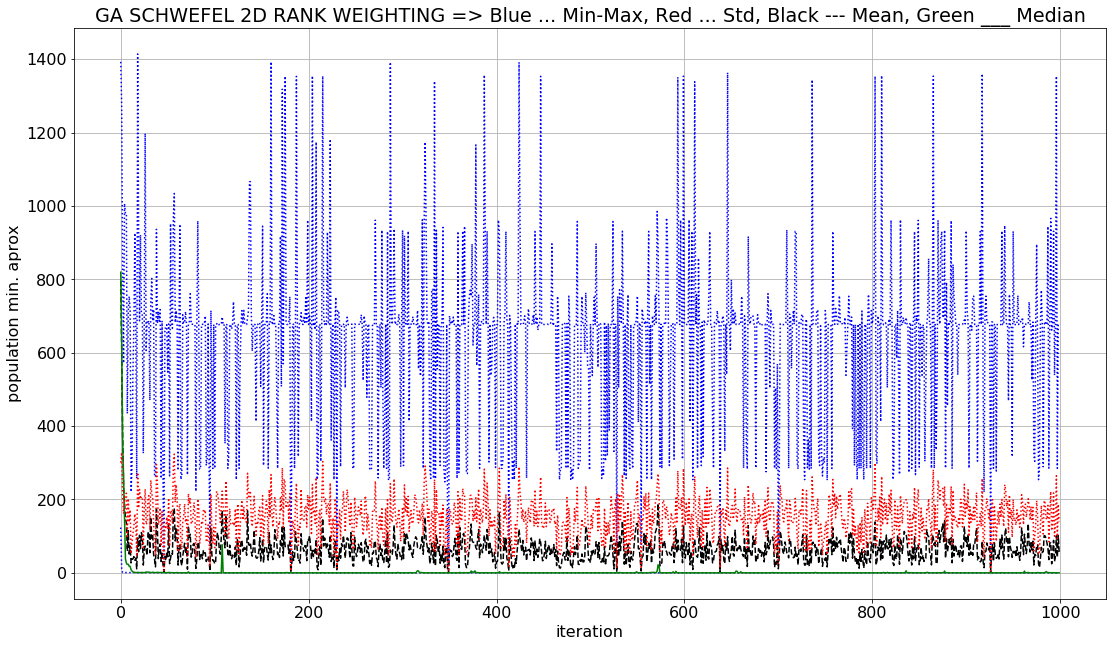

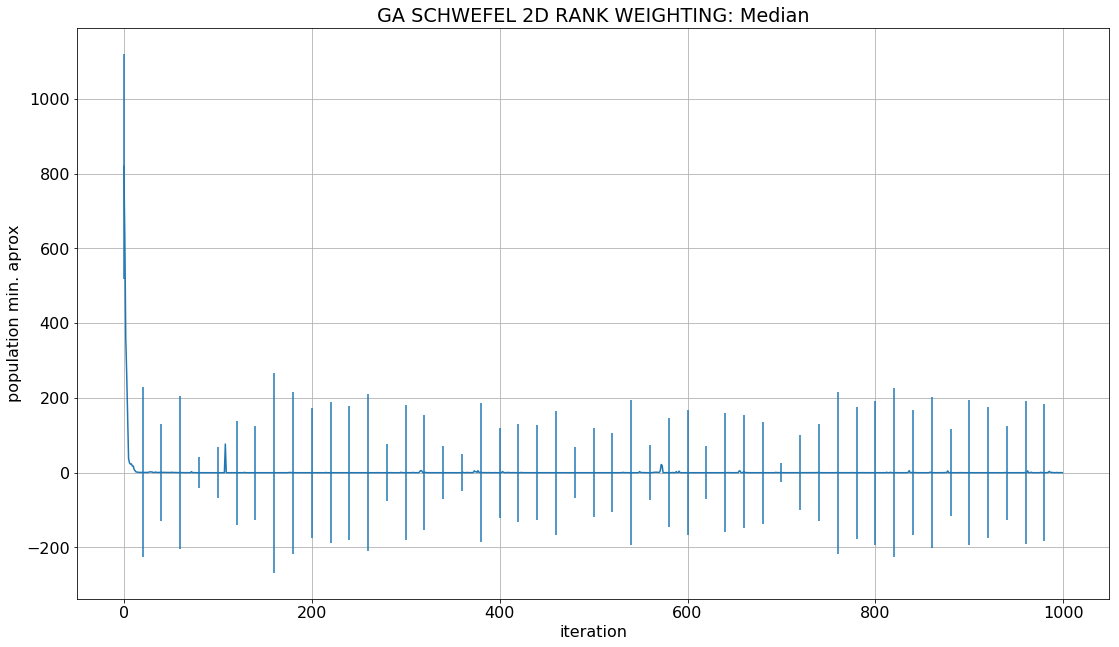

In [1426]:
# Generate population
N = 32
minVal = 100
maxVal = 500
codeLen = 16
genQty = 2
d = codeLen * genQty
iterations = 1000
matingPercent = 0.7
mutaPercent = 0.03
# Initial population
Pop = ga.pgenerator(N=N,d =d)
# Evolving output matrix
OUT_Matrix = np.zeros((5, iterations))
Iterations = []


for i in range(iterations):
    sys.stdout.write("\r Iteration " + str(i))
    sys.stdout.flush()
    Iterations.append(i)
    # Workout population fitness
    fitList,fitVal = ga.popfitnes(pop = Pop,minVal = minVal, maxVal = maxVal, codeLen = codeLen, genQty = genQty, funct = Schwefel)
    OUT_Matrix[0][i] = np.mean(fitList)
    OUT_Matrix[1][i] = np.median(fitList)
    OUT_Matrix[2][i] = np.max(fitList)
    OUT_Matrix[3][i] = np.min(fitList)
    OUT_Matrix[4][i] = np.std(fitList)
    
    ordPop,ordFitVal,ordFitLst,rankWeighting = ga.rankWeighting(fitList,fitVal,Pop,keep = 1)
    pselect = ga.weightedSelection(ordPop, rankWeighting, int(N/2))
    if i == (iterations - 1):
        # in last iteration children are equal to parents
        matingPercent = -1   
    children = ga.childenGen(pselect, matingPercent = matingPercent, mutaPercent = mutaPercent)
    Pop = children
    
# Last populatio fitness
print('\n')
print('Last fit info______')
print('Last fit mean: ' + str(np.mean(fitList)))
print('Last fit std: ' + str(np.std(fitList)))
print('Last fit median: ' + str(np.median(fitList)))
print('Last fit min: ' + str(np.amin(fitList)))
print('Last fit max: ' + str(np.amax(fitList)))
print('Last Pop info______')
print('Last Pop mean: ' + str(np.mean(fitVal, axis=0)))
print('Last Pop std: ' + str(np.std(fitVal, axis=0)))
print('Last Pop median: ' + str(np.median(fitVal, axis=0)))
print('Last Pop min: ' + str(np.amin(fitVal, axis=0)))
print('Last Pop max: ' + str(np.amax(fitVal, axis=0)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[2]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[3]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[0]),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[1]),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[4]),
         'r:',)

plt.ylabel('population min. aprox')
plt.xlabel('iteration')
plt.title("GA SCHWEFEL 2D RANK WEIGHTING => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('schwefelRankWeightingGA_2d.pdf', format='pdf')
plt.show()

# Standard Deviation Plot
Ala = OUT_Matrix[4]
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:20] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, OUT_Matrix[1], truncated)
plt.ylabel('population min. aprox')
plt.xlabel('iteration')
plt.title("GA SCHWEFEL 2D RANK WEIGHTING: Median")
plt.grid()
plt.savefig('schwefelRankWeightingGAStd_2d.pdf', format='pdf')
plt.show()

## schwefelRankWeightingGA_10d.pdf

 Iteration 9999

Last fit info______
Last fit mean: 125.60280461765961
Last fit std: 215.30646442630348
Last fit median: 6.815549385316444
Last fit min: 0.14664996074043302
Last fit max: 966.4447292778441
Last Pop info______
Last Pop mean: [415.00071527 418.01461051 419.35058556 420.22607195 419.95012207
 419.01717594 421.19034676 417.60314145 417.49394408 419.33766308]
Last Pop std: [35.91878112 25.49167222 13.28509706 22.26343273 14.08603926 19.2023555
  5.64066488 26.691443   22.13341696 13.36741093]
Last Pop median: [420.49744411 421.19935912 420.8392462  420.45471885 421.30922408
 420.46692607 421.10780499 420.54627298 421.22987716 420.77210651]
Last Pop min: [220.10376135 220.32349126 320.8377203  223.16166934 320.51422904
 214.21988251 408.65644312 220.54322118 220.60425727 320.74616617]
Last Pop max: [471.24895094 471.20622568 470.84000916 470.80949111 470.91935607
 470.4554818  474.57541772 445.1560235  471.24284733 470.72404059]


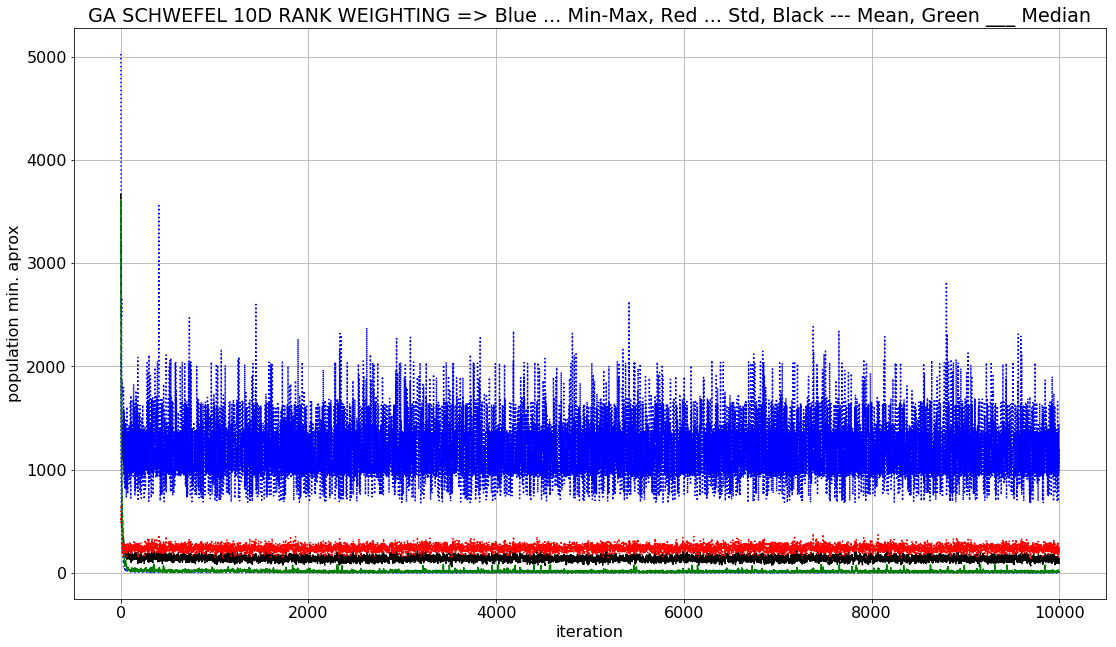

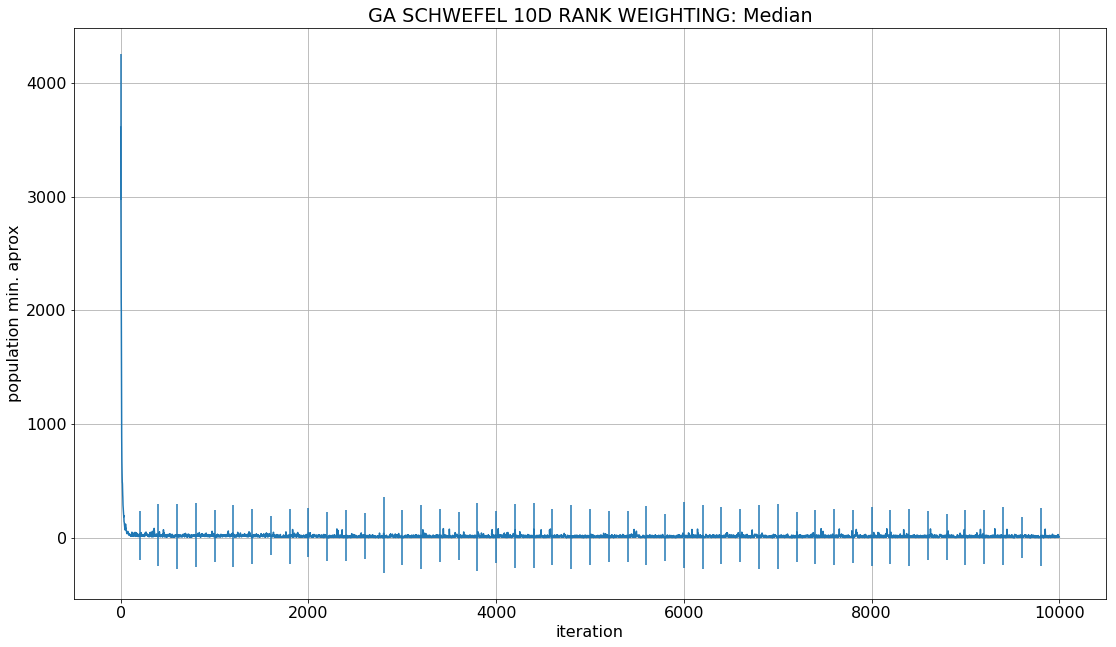

In [1431]:
# Generate population
N = 128
minVal = 100
maxVal = 500
codeLen = 16
genQty = 10
d = codeLen * genQty
iterations = 10000
matingPercent = 0.8
mutaPercent = 0.01
# Initial population
Pop = ga.pgenerator(N=N,d =d)
# Evolving output matrix
OUT_Matrix = np.zeros((5, iterations))
Iterations = []


for i in range(iterations):
    sys.stdout.write("\r Iteration " + str(i))
    sys.stdout.flush()
    Iterations.append(i)
    # Workout population fitness
    fitList,fitVal = ga.popfitnes(pop = Pop,minVal = minVal, maxVal = maxVal, codeLen = codeLen, genQty = genQty, funct = Schwefel)
    OUT_Matrix[0][i] = np.mean(fitList)
    OUT_Matrix[1][i] = np.median(fitList)
    OUT_Matrix[2][i] = np.max(fitList)
    OUT_Matrix[3][i] = np.min(fitList)
    OUT_Matrix[4][i] = np.std(fitList)
    
    ordPop,ordFitVal,ordFitLst,rankWeighting = ga.rankWeighting(fitList,fitVal,Pop,keep = 1)
    pselect = ga.weightedSelection(ordPop, rankWeighting, int(N/2))
    if i == (iterations - 1):
        # in last iteration children are equal to parents
        matingPercent = -1   
    children = ga.childenGen(pselect, matingPercent = matingPercent, mutaPercent = mutaPercent)
    Pop = children
    
# Last populatio fitness
print('\n')
print('Last fit info______')
print('Last fit mean: ' + str(np.mean(fitList)))
print('Last fit std: ' + str(np.std(fitList)))
print('Last fit median: ' + str(np.median(fitList)))
print('Last fit min: ' + str(np.amin(fitList)))
print('Last fit max: ' + str(np.amax(fitList)))
print('Last Pop info______')
print('Last Pop mean: ' + str(np.mean(fitVal, axis=0)))
print('Last Pop std: ' + str(np.std(fitVal, axis=0)))
print('Last Pop median: ' + str(np.median(fitVal, axis=0)))
print('Last Pop min: ' + str(np.amin(fitVal, axis=0)))
print('Last Pop max: ' + str(np.amax(fitVal, axis=0)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[2]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[3]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[0]),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[1]),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[4]),
         'r:',)

plt.ylabel('population min. aprox')
plt.xlabel('iteration')
plt.title("GA SCHWEFEL 10D RANK WEIGHTING => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('schwefelRankWeightingGA_10d.pdf', format='pdf')
plt.show()

# Standard Deviation Plot
Ala = OUT_Matrix[4]
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, OUT_Matrix[1], truncated)
plt.ylabel('population min. aprox')
plt.xlabel('iteration')
plt.title("GA SCHWEFEL 10D RANK WEIGHTING: Median")
plt.grid()
plt.savefig('schwefelRankWeightingGAStd_10d.pdf', format='pdf')
plt.show()

## schwefelCostWeightingGA_2d.pdf

 Iteration 999

Last fit info______
Last fit mean: 16.396915310400928
Last fit std: 35.7968054747476
Last fit median: 2.9213281450484487
Last fit min: 0.06428948601865159
Last fit max: 276.36259363216266
Last Pop info______
Last Pop mean: [417.77394713 419.60984588]
Last Pop std: [19.64143227  6.16485204]
Last Pop median: [420.10681315 418.52903029]
Last Pop min: [219.20042725 403.68810559]
Last Pop max: [469.98550393 444.9485008 ]


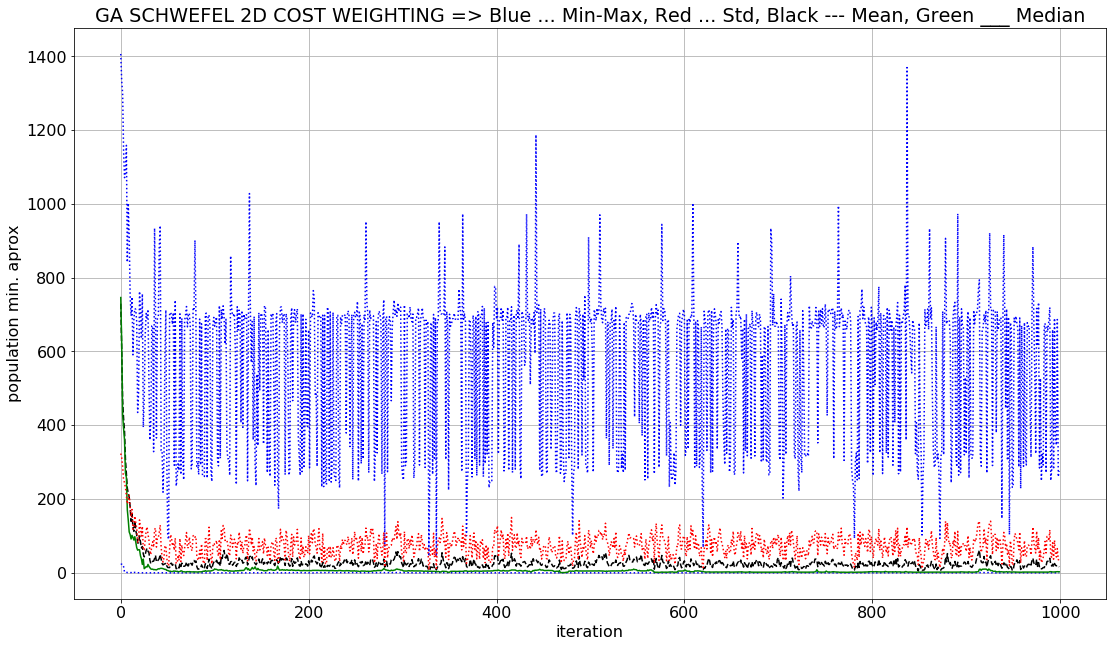

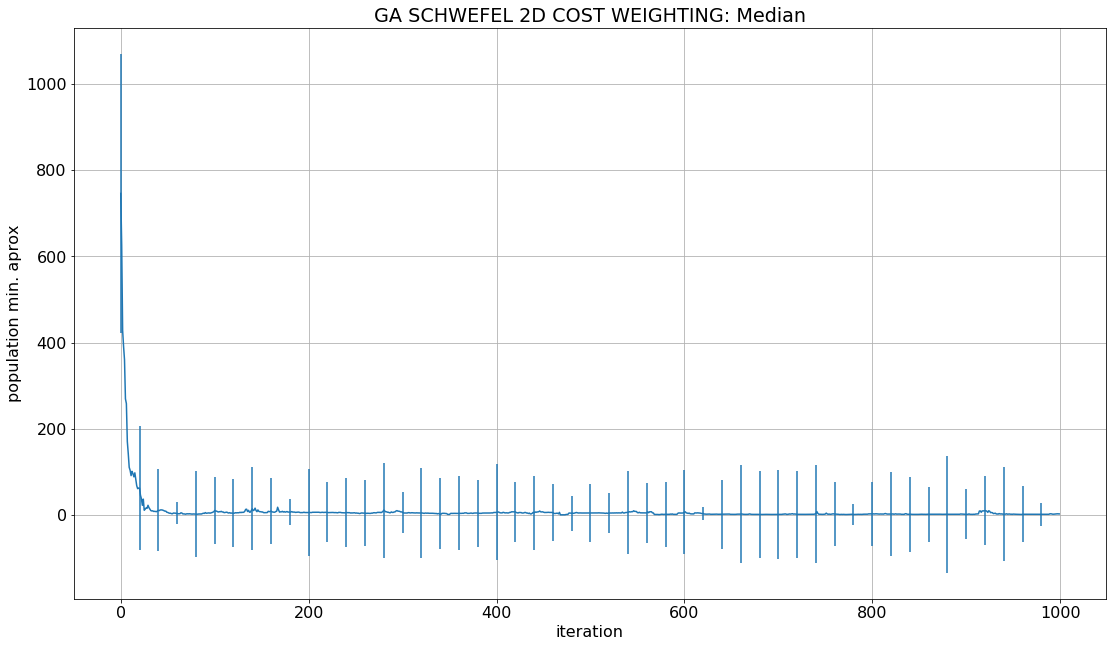

In [1441]:
# Generate population
N = 128
minVal = 100
maxVal = 500
codeLen = 16
genQty = 2
d = codeLen * genQty
iterations = 1000
matingPercent = 0.8
mutaPercent = 0.005
# Initial population
Pop = ga.pgenerator(N=N,d =d)
# Evolving output matrix
OUT_Matrix = np.zeros((5, iterations))
Iterations = []


for i in range(iterations):
    sys.stdout.write("\r Iteration " + str(i))
    sys.stdout.flush()
    Iterations.append(i)
    # Workout population fitness
    fitList,fitVal = ga.popfitnes(pop = Pop,minVal = minVal, maxVal = maxVal, codeLen = codeLen, genQty = genQty, funct = Schwefel)
    OUT_Matrix[0][i] = np.mean(fitList)
    OUT_Matrix[1][i] = np.median(fitList)
    OUT_Matrix[2][i] = np.max(fitList)
    OUT_Matrix[3][i] = np.min(fitList)
    OUT_Matrix[4][i] = np.std(fitList)
    
    ordPop,ordFitVal,ordFitLst,costWeighting = ga.costWeighting(fitList,fitVal,Pop,keep = 1)
    pselect = ga.weightedSelection(ordPop, costWeighting, int(N/2))
    if i == (iterations - 1):
        # in last iteration children are equal to parents
        matingPercent = -1   
    children = ga.childenGen(pselect, matingPercent = matingPercent, mutaPercent = mutaPercent)
    Pop = children
    
# Last populatio fitness
print('\n')
print('Last fit info______')
print('Last fit mean: ' + str(np.mean(fitList)))
print('Last fit std: ' + str(np.std(fitList)))
print('Last fit median: ' + str(np.median(fitList)))
print('Last fit min: ' + str(np.amin(fitList)))
print('Last fit max: ' + str(np.amax(fitList)))
print('Last Pop info______')
print('Last Pop mean: ' + str(np.mean(fitVal, axis=0)))
print('Last Pop std: ' + str(np.std(fitVal, axis=0)))
print('Last Pop median: ' + str(np.median(fitVal, axis=0)))
print('Last Pop min: ' + str(np.amin(fitVal, axis=0)))
print('Last Pop max: ' + str(np.amax(fitVal, axis=0)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[2]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[3]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[0]),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[1]),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[4]),
         'r:',)

plt.ylabel('population min. aprox')
plt.xlabel('iteration')
plt.title("GA SCHWEFEL 2D COST WEIGHTING => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('schwefelCostWeightingGA_2d.pdf', format='pdf')
plt.show()

# Standard Deviation Plot
Ala = OUT_Matrix[4]
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:20] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, OUT_Matrix[1], truncated)
plt.ylabel('population min. aprox')
plt.xlabel('iteration')
plt.title("GA SCHWEFEL 2D COST WEIGHTING: Median")
plt.grid()
plt.savefig('schwefelCostWeightingGAStd_2d.pdf', format='pdf')
plt.show()

## schwefelCostWeightingGA_10d.pdf

 Iteration 9999

Last fit info______
Last fit mean: 108.5396167391839
Last fit std: 168.78229431156785
Last fit median: 63.07322517995772
Last fit min: 10.834818660042401
Last fit max: 1526.1716274507808
Last Pop info______
Last Pop mean: [419.64937629 422.58793011 425.075103   420.83853094 416.16330968
 420.67874037 415.03595407 411.04381247 414.99623293 419.68022812]
Last Pop std: [ 6.38142472 18.79683596 12.10655744 36.1495882   9.65757743  3.64254981
 26.16826075  7.88308421  4.33220754  9.42140172]
Last Pop median: [421.62661173 423.57976654 419.10582132 426.43320363 416.53620203
 422.63981079 420.18005646 405.62294957 416.61554894 419.87487602]
Last Pop min: [411.9157702  223.60112917 411.04295415 226.40268559 316.53467613
 407.08781567 208.94636454 404.69520104 404.50598917 319.72686351]
Last Pop max: [446.71244373 473.60494392 449.32478828 434.18173495 443.09910735
 432.47882811 471.74334325 457.96749828 441.61593042 444.8752575 ]


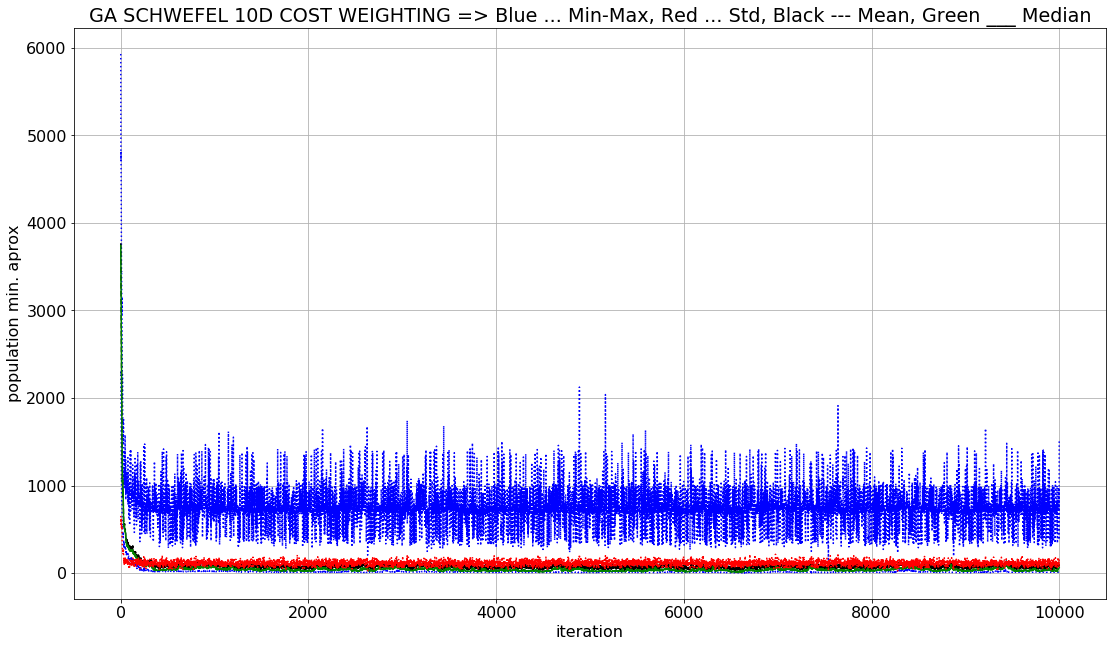

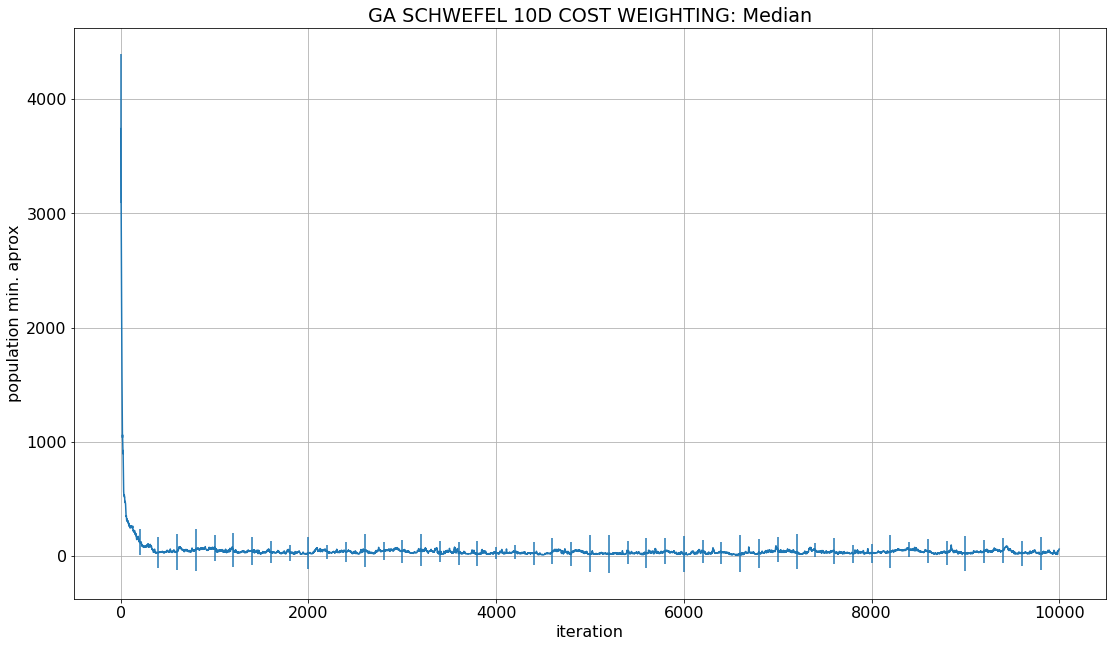

In [14]:
# Generate population
N = 128
minVal = 100
maxVal = 500
codeLen = 16
genQty = 10
d = codeLen * genQty
iterations = 10000
matingPercent = 0.7
mutaPercent = 0.002
# Initial population
Pop = ga.pgenerator(N=N,d =d)
# Evolving output matrix
OUT_Matrix = np.zeros((5, iterations))
Iterations = []


for i in range(iterations):
    sys.stdout.write("\r Iteration " + str(i))
    sys.stdout.flush()
    Iterations.append(i)
    # Workout population fitness
    fitList,fitVal = ga.popfitnes(pop = Pop,minVal = minVal, maxVal = maxVal, codeLen = codeLen, genQty = genQty, funct = Schwefel)
    OUT_Matrix[0][i] = np.mean(fitList)
    OUT_Matrix[1][i] = np.median(fitList)
    OUT_Matrix[2][i] = np.max(fitList)
    OUT_Matrix[3][i] = np.min(fitList)
    OUT_Matrix[4][i] = np.std(fitList)
    
    ordPop,ordFitVal,ordFitLst,costWeighting = ga.costWeighting(fitList,fitVal,Pop,keep = 1)
    pselect = ga.weightedSelection(ordPop, costWeighting, int(N/2))
    if i == (iterations - 1):
        # in last iteration children are equal to parents
        matingPercent = -1   
    children = ga.childenGen(pselect, matingPercent = matingPercent, mutaPercent = mutaPercent)
    Pop = children
    
# Last populatio fitness
print('\n')
print('Last fit info______')
print('Last fit mean: ' + str(np.mean(fitList)))
print('Last fit std: ' + str(np.std(fitList)))
print('Last fit median: ' + str(np.median(fitList)))
print('Last fit min: ' + str(np.amin(fitList)))
print('Last fit max: ' + str(np.amax(fitList)))
print('Last Pop info______')
print('Last Pop mean: ' + str(np.mean(fitVal, axis=0)))
print('Last Pop std: ' + str(np.std(fitVal, axis=0)))
print('Last Pop median: ' + str(np.median(fitVal, axis=0)))
print('Last Pop min: ' + str(np.amin(fitVal, axis=0)))
print('Last Pop max: ' + str(np.amax(fitVal, axis=0)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[2]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[3]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[0]),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[1]),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[4]),
         'r:',)

plt.ylabel('population min. aprox')
plt.xlabel('iteration')
plt.title("GA SCHWEFEL 10D COST WEIGHTING => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('schwefelCostWeightingGA_10d.pdf', format='pdf')
plt.show()

# Standard Deviation Plot
Ala = OUT_Matrix[4]
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, OUT_Matrix[1], truncated)
plt.ylabel('population min. aprox')
plt.xlabel('iteration')
plt.title("GA SCHWEFEL 10D COST WEIGHTING: Median")
plt.grid()
plt.savefig('schwefelCostWeightingGAStd_10d.pdf', format='pdf')
plt.show()

# min_Schwefel HAEA
## 2D

 Iteration 99

Last fit info______
Last fit mean: 2.5897774094119086e-05
Last fit std: 0.0
Last fit median: 2.5897774094119086e-05
Last fit min: 2.5897774094119086e-05
Last fit max: 2.5897774094119086e-05
Last Pop info______
Last Pop mean: [1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 0.]
Last Pop std: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Last Pop median: [1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 0.]
Last Pop min: [1 1 0 0 1 1 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 1 0]
Last Pop max: [1 1 0 0 1 1 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 1 0]


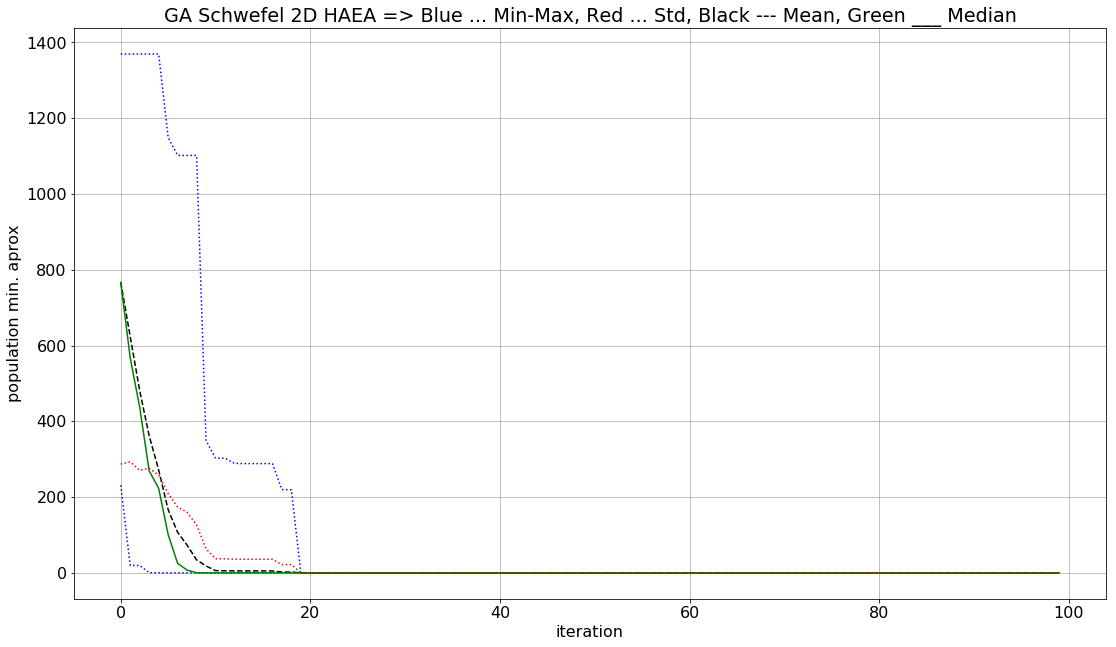

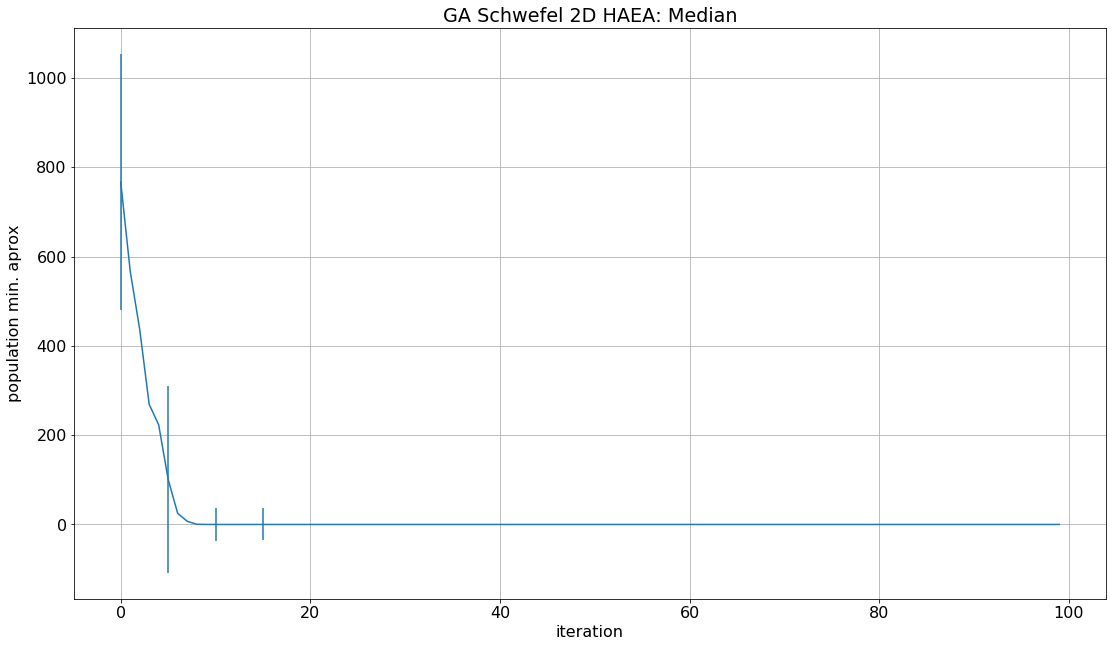

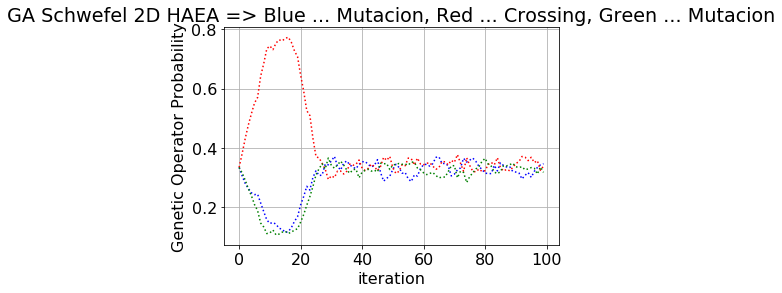

[[0.19704519 0.02447755 0.77847726]
 [0.11676033 0.68654692 0.19669274]
 [0.59902192 0.23128606 0.16969202]
 [0.17990216 0.69332844 0.12676941]
 [0.6330746  0.12949685 0.23742855]
 [0.5421455  0.40545826 0.05239624]
 [0.16649704 0.46532586 0.36817711]
 [0.59880491 0.14365501 0.25754007]
 [0.34160451 0.0209111  0.63748438]
 [0.01999775 0.95893589 0.02106637]
 [0.10320804 0.33735794 0.55943402]
 [0.58977966 0.22107732 0.18914302]
 [0.13482069 0.80328453 0.06189477]
 [0.47768919 0.19500068 0.32731013]
 [0.22014869 0.60463839 0.17521291]
 [0.38515788 0.55663644 0.05820568]
 [0.09403938 0.57800823 0.32795239]
 [0.33245691 0.4610834  0.20645968]
 [0.28738628 0.47805046 0.23456327]
 [0.84021947 0.10529234 0.05448819]
 [0.16592082 0.57606648 0.2580127 ]
 [0.07221698 0.10149324 0.82628978]
 [0.61104121 0.14280018 0.2461586 ]
 [0.10001312 0.06424543 0.83574145]
 [0.86707977 0.06295061 0.06996962]
 [0.28954326 0.57477131 0.13568543]
 [0.15242961 0.13358053 0.71398985]
 [0.02139116 0.66005233 0.31

In [5]:
# Generate population
N = 100
minVal = 100
maxVal = 500
codeLen = 16
genQty = 2
d = codeLen * genQty
# Not used
lnrate = 1
mutationP = 1/d
iterations = 100
# Initial population
Pop = ga.pgenerator(N=N,d =d)
# print(Pop)
# Generation of inital random GA operator application probabilities
# 0: Mutation, 1: Mating
gopp = ga.pgenerator4Gop(N=N,d = 3)
# print(gopp)
# Evolving output matrix
OUT_Matrix = np.zeros((5, iterations))
GOP_Matrix = np.zeros((3, iterations))
Iterations = []


for i in range(iterations):
    sys.stdout.write("\r Iteration " + str(i))
    sys.stdout.flush()
    Iterations.append(i)
    # Workout population fitness
    fitList,fitVal = ga.popfitnes(pop = Pop,minVal = minVal, maxVal = maxVal, codeLen = codeLen, genQty = genQty, funct = Schwefel)
    OUT_Matrix[0][i] = np.mean(fitList)
    OUT_Matrix[1][i] = np.median(fitList)
    OUT_Matrix[2][i] = np.max(fitList)
    OUT_Matrix[3][i] = np.min(fitList)
    OUT_Matrix[4][i] = np.std(fitList)
    GOP_Matrix[0][i] = np.mean(gopp[:,0])
    GOP_Matrix[1][i] = np.mean(gopp[:,1])
    GOP_Matrix[2][i] = np.mean(gopp[:,2])
    pselect = ga.tournamentSelection(Pop, fitList, int(N/2))
    children,gopp = ga.haeaMin(Pop, pselect, gopp, fitList, SchwefelBinString, mutationP, lnrate)
    
    Pop = children
    # print("New Population")
    # print(Pop)
    
# Last populatio fitness
print('\n')
print('Last fit info______')
print('Last fit mean: ' + str(np.mean(fitList)))
print('Last fit std: ' + str(np.std(fitList)))
print('Last fit median: ' + str(np.median(fitList)))
print('Last fit min: ' + str(np.amin(fitList)))
print('Last fit max: ' + str(np.amax(fitList)))
print('Last Pop info______')
print('Last Pop mean: ' + str(np.mean(Pop, axis=0)))
print('Last Pop std: ' + str(np.std(Pop, axis=0)))
print('Last Pop median: ' + str(np.median(Pop, axis=0)))
print('Last Pop min: ' + str(np.amin(Pop, axis=0)))
print('Last Pop max: ' + str(np.amax(Pop, axis=0)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[2]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[3]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[0]),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[1]),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[4]),
         'r:',)

plt.ylabel('population min. aprox')
plt.xlabel('iteration')
plt.title("GA Schwefel 2D HAEA => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('SchwefelHaeaGA_2d.pdf', format='pdf')
plt.show()

# Standard Deviation Plot
Ala = OUT_Matrix[4]
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:5] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, OUT_Matrix[1], truncated)
plt.ylabel('population min. aprox')
plt.xlabel('iteration')
plt.title("GA Schwefel 2D HAEA: Median")
plt.grid()
plt.savefig('SchwefelHaeaGAStd_2d.pdf', format='pdf')
plt.show()


plt.plot(np.squeeze(Iterations),
         np.squeeze(GOP_Matrix[0]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(GOP_Matrix[1]),
         'r:',
         np.squeeze(Iterations),
         np.squeeze(GOP_Matrix[2]),
         'g:',)

plt.ylabel('Genetic Operator Probability')
plt.xlabel('iteration')
plt.title("GA Schwefel 2D HAEA => Blue ... Mutacion, Red ... Crossing, Green ... Mutacion")
plt.grid()
plt.savefig('geneticOperatorSchwefel_2d.pdf', format='pdf')
plt.show()

print(gopp)

# min_Schwefel HAEA
## 10D

 Iteration 399

Last fit info______
Last fit mean: 7.119175635535612
Last fit std: 0.0
Last fit median: 7.119175635535612
Last fit min: 7.119175635535612
Last fit max: 7.119175635535612
Last Pop info______
Last Pop mean: [1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Last Pop std: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

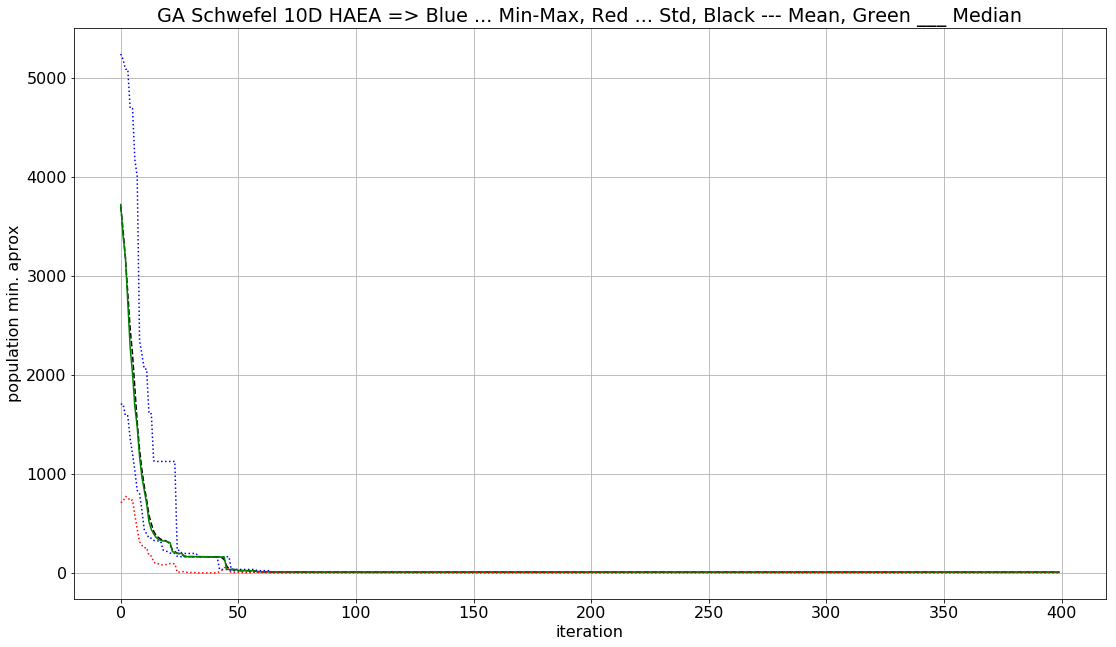

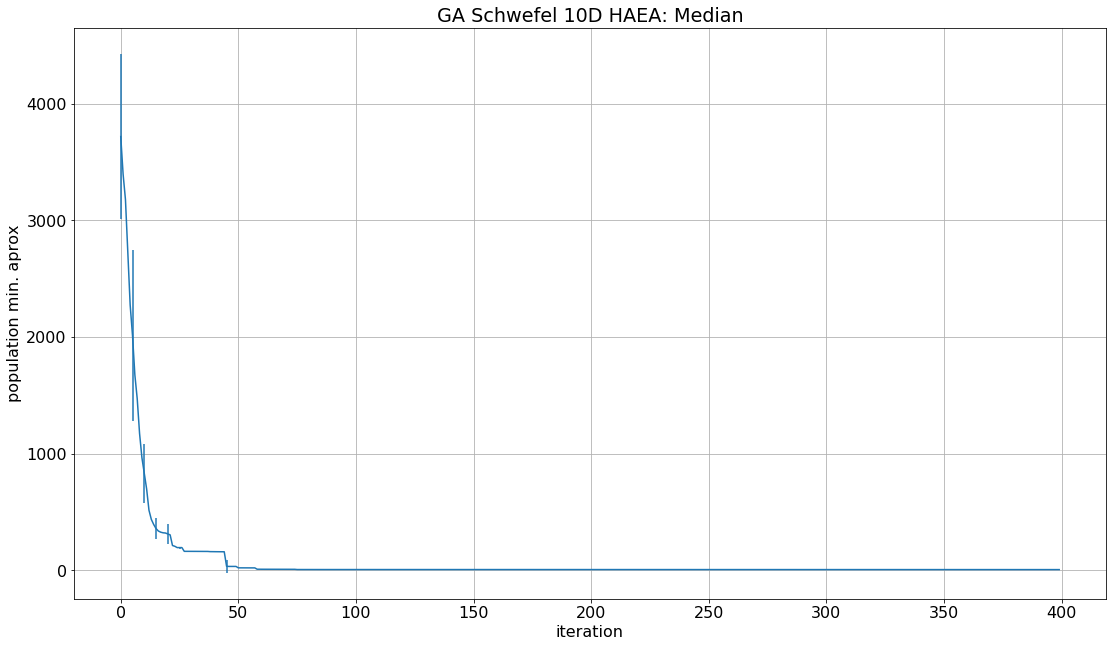

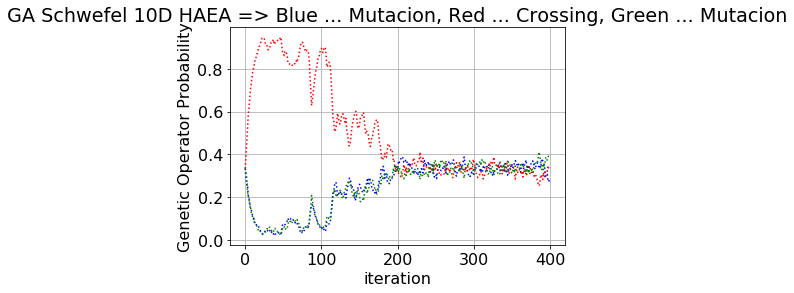

[[4.33101341e-01 5.18067794e-01 4.88308655e-02]
 [2.32316226e-01 3.95659209e-01 3.72024565e-01]
 [9.10076213e-02 8.21844395e-01 8.71479833e-02]
 [2.26382456e-01 4.81297554e-01 2.92319989e-01]
 [5.16521702e-01 7.30405001e-03 4.76174248e-01]
 [2.85881825e-01 2.33914726e-01 4.80203449e-01]
 [3.98335836e-01 4.74985880e-01 1.26678283e-01]
 [4.22371047e-01 4.57257493e-01 1.20371461e-01]
 [1.39560907e-01 9.57131089e-02 7.64725984e-01]
 [6.63288218e-02 8.14252943e-01 1.19418235e-01]
 [4.76913358e-03 2.68604910e-01 7.26625956e-01]
 [6.55007619e-02 8.38630357e-01 9.58688815e-02]
 [4.12381390e-01 2.77547335e-01 3.10071275e-01]
 [4.99380182e-01 2.10949480e-01 2.89670338e-01]
 [1.71435122e-01 7.42058288e-01 8.65065903e-02]
 [1.65454034e-01 5.82452487e-01 2.52093479e-01]
 [2.31717857e-01 1.97149276e-01 5.71132867e-01]
 [6.58190523e-01 2.78618952e-01 6.31905251e-02]
 [8.69345524e-02 1.64972799e-03 9.11415720e-01]
 [7.90339591e-02 3.18778034e-01 6.02188007e-01]
 [6.20489867e-01 2.09434602e-02 3.585666

In [7]:
# Generate population
N = 100
minVal = 100
maxVal = 500
codeLen = 16
genQty = 10
d = codeLen * genQty
# Not used
lnrate = 1
mutationP = 1/d
iterations = 400
# Initial population
Pop = ga.pgenerator(N=N,d =d)
# print(Pop)
# Generation of inital random GA operator application probabilities
# 0: Mutation, 1: Mating
gopp = ga.pgenerator4Gop(N=N,d = 3)
# print(gopp)
# Evolving output matrix
OUT_Matrix = np.zeros((5, iterations))
GOP_Matrix = np.zeros((3, iterations))
Iterations = []


for i in range(iterations):
    sys.stdout.write("\r Iteration " + str(i))
    sys.stdout.flush()
    Iterations.append(i)
    # Workout population fitness
    fitList,fitVal = ga.popfitnes(pop = Pop,minVal = minVal, maxVal = maxVal, codeLen = codeLen, genQty = genQty, funct = Schwefel)
    OUT_Matrix[0][i] = np.mean(fitList)
    OUT_Matrix[1][i] = np.median(fitList)
    OUT_Matrix[2][i] = np.max(fitList)
    OUT_Matrix[3][i] = np.min(fitList)
    OUT_Matrix[4][i] = np.std(fitList)
    GOP_Matrix[0][i] = np.mean(gopp[:,0])
    GOP_Matrix[1][i] = np.mean(gopp[:,1])
    GOP_Matrix[2][i] = np.mean(gopp[:,2])
    pselect = ga.tournamentSelection(Pop, fitList, int(N/2))
    children,gopp = ga.haeaMin(Pop, pselect, gopp, fitList, SchwefelBinString, mutationP, lnrate)
    
    Pop = children
    # print("New Population")
    # print(Pop)
    
# Last populatio fitness
print('\n')
print('Last fit info______')
print('Last fit mean: ' + str(np.mean(fitList)))
print('Last fit std: ' + str(np.std(fitList)))
print('Last fit median: ' + str(np.median(fitList)))
print('Last fit min: ' + str(np.amin(fitList)))
print('Last fit max: ' + str(np.amax(fitList)))
print('Last Pop info______')
print('Last Pop mean: ' + str(np.mean(Pop, axis=0)))
print('Last Pop std: ' + str(np.std(Pop, axis=0)))
print('Last Pop median: ' + str(np.median(Pop, axis=0)))
print('Last Pop min: ' + str(np.amin(Pop, axis=0)))
print('Last Pop max: ' + str(np.amax(Pop, axis=0)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[2]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[3]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[0]),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[1]),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(OUT_Matrix[4]),
         'r:',)

plt.ylabel('population min. aprox')
plt.xlabel('iteration')
plt.title("GA Schwefel 10D HAEA => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('SchwefelHaeaGA_10d.pdf', format='pdf')
plt.show()

# Standard Deviation Plot
Ala = OUT_Matrix[4]
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:5] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, OUT_Matrix[1], truncated)
plt.ylabel('population min. aprox')
plt.xlabel('iteration')
plt.title("GA Schwefel 10D HAEA: Median")
plt.grid()
plt.savefig('SchwefelHaeaGAStd_10d.pdf', format='pdf')
plt.show()


plt.plot(np.squeeze(Iterations),
         np.squeeze(GOP_Matrix[0]),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(GOP_Matrix[1]),
         'r:',
         np.squeeze(Iterations),
         np.squeeze(GOP_Matrix[2]),
         'g:',)

plt.ylabel('Genetic Operator Probability')
plt.xlabel('iteration')
plt.title("GA Schwefel 10D HAEA => Blue ... Mutacion, Red ... Crossing, Green ... Mutacion")
plt.grid()
plt.savefig('geneticOperatorSchwefel_10d.pdf', format='pdf')
plt.show()

print(gopp)